In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler


## Abrindo dados

In [2]:
df_cluster = pd.read_parquet(path="./../data/clean_data/category_seasonal_data.parquet")
df_cluster

filtered_category commercial_dates  comdate_diff  freight_value  \
0                      Outros       2017-05-14             2          21.88   
1       Utilidades Domesticas       2018-01-01            11          46.48   
2                      Outros       2018-05-13             6          17.79   
3                      Outros       2018-03-08             5          23.36   
4                      Outros       2018-08-12           -14          22.25   
...                       ...              ...           ...            ...   
115013                 Outros       2018-04-01             6          13.88   
115014          Esporte Lazer       2018-04-01             3          14.16   
115015           Beleza Saude       2018-04-01             7          19.04   
115016     Relogios Presentes       2017-11-24           -21          22.07   
115017             Perfumaria       2017-12-25            -6           7.78   

         price order_purchase_timestamp time_window_order_names  \
0       124.99               2017-05-16    Mais de duas semanas   
1       289.00               2018-01-12    Mais de duas semanas   
2       139.94               2018-05-19    Mais de duas semanas   
3       149.94               2018-03-13    Mais de duas semanas   
4       230.00               2018-07-29            Duas semanas   
...        ...                      ...                     ...   
115013   74.90               2018-04-07    Mais de duas semanas   
115014  114.90               2018-04-04    Mais de duas semanas   
115015   37.00               2018-04-08    Mais de duas semanas   
115016  689.00               2017-11-03            Duas semanas   
115017   13.99               2017-12-19              Uma semana   

       commercial_date_names  days_since_year_start  days_since_month_start  \
0               Dia das Maes                    133                      13   
1                  Reveillon                      0                       0   
2               Dia das Maes                    132                      12   
3              Dia da Mulher                     66                       7   
4               Dia dos Pais                    223                      11   
...                      ...                    ...                     ...   
115013                Pascoa                     90                       0   
115014                Pascoa                     90                       0   
115015                Pascoa                     90                       0   
115016          Black Friday                    327                      23   
115017                 Natal                    358                      24   

        year  month  day_of_month  day_of_week  filtered_category_coded  \
0       2017      5            14            6                       10   
1       2018      1             1            0                       14   
2       2018      5            13            6                       10   
3       2018      3             8            3                       10   
4       2018      8            12            6                       10   
...      ...    ...           ...          ...                      ...   
115013  2018      4             1            6                       10   
115014  2018      4             1            6                        6   
115015  2018      4             1            6                        2   
115016  2017     11            24            4                       12   
115017  2017     12            25            0                       11   

        commercial_date_coded  time_window_order_coded  
0                           3                        1  
1                           9                        1  
2                           3                        1  
3                           1                        1  
4                           5                        0  
...                       ...                      ...  
115013   

## Encontrando a melhor versão do dataframe
### Opções:
    Original
    Normalizado
    Padronizado

### Limpando colunas e linhas não utilizadas

In [44]:
df_cluster = df_cluster[df_cluster['filtered_category'] != 'Outros']
df_cluster = df_cluster.drop('commercial_dates', axis=1)
df_cluster = df_cluster.drop('filtered_category', axis=1)
df_cluster = df_cluster.drop('commercial_date_names', axis=1)
df_cluster = df_cluster.drop('time_window_order_names', axis=1)
df_cluster = df_cluster.drop('order_purchase_timestamp', axis=1)
df_cluster.reset_index(drop=True, inplace=True)
df_cluster

comdate_diff  freight_value   price  days_since_year_start  \
0                11          46.48  289.00                      0   
1               -28          22.31  259.90                    284   
2               -17           7.78   14.99                     66   
3                17          14.10   25.00                      0   
4                 7          22.57   99.90                      0   
...             ...            ...     ...                    ...   
87849            -8          20.88   55.00                    358   
87850             3          14.16  114.90                     90   
87851             7          19.04   37.00                     90   
87852           -21          22.07  689.00                    327   
87853            -6           7.78   13.99                    358   

       days_since_month_start  year  month  day_of_month  day_of_week  \
0                           0  2018      1             1            0   
1                          11  2017     10            12            3   
2                           7  2018      3             8            3   
3                           0  2018      1             1            0   
4                           0  2018      1             1            0   
...                       ...   ...    ...           ...          ...   
87849                      24  2017     12            25            0   
87850                       0  2018      4             1            6   
87851                       0  2018      4             1            6   
87852                      23  2017     11            24            4   
87853                      24  2017     12            25            0   

       filtered_category_coded  commercial_date_coded  \
0                           14                      9   
1                            6                      7   
2                            8                      1   
3                            3                      9   
4                            9                      9   
...                        ...                    ...   
87849                       14                      6   
87850                        6                      8   
87851                        2                      8   
87852                       12                      0   
87853                       11                      6   

       time_window_order_coded  kmeans_4  kmeans_8  
0                            1       1.0       4.0  
1                            1       0.0       0.0  
2                            0       3.0       6.0  
3                            1       2.0       2.0  
4                            1       3.0       7.0  
...                        ...       ...       ...  
87849                        0       NaN       NaN  
87850                        1       NaN       NaN  
87851                        1       NaN       NaN  
87852                        0       NaN       NaN  
87853                        2       NaN       NaN  

[87854 rows x 14 columns]

### Testando sample de 10000 linhas

In [4]:
df_sample_10 = df_cluster.sample(n=10000, random_state=42)

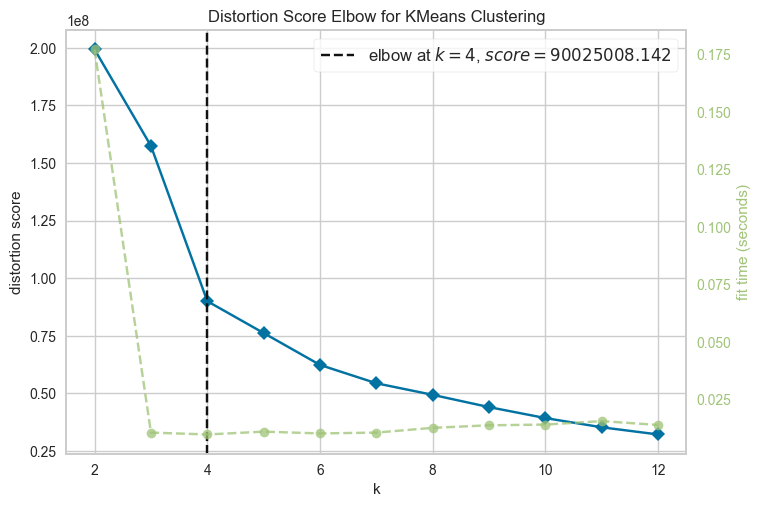

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 13))
visualizer.fit(df_sample_10)
visualizer.show()


Text(0.5, 1.0, 'clusters = 4\nscore = 0.4570554193303579')

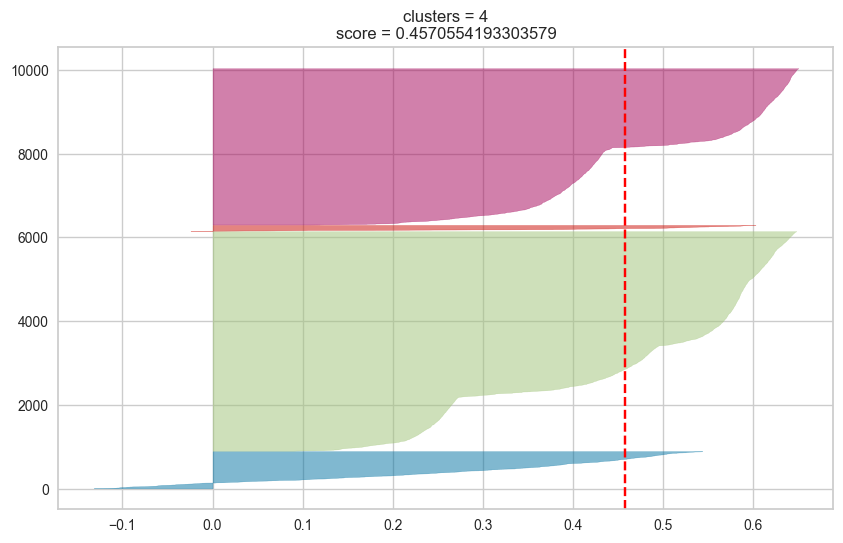

In [6]:
nCluster = 4
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

km = KMeans(n_clusters=nCluster, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax1)
visualizer.fit(df_sample_10)
ax1.set_title(f"clusters = {nCluster}\nscore = {visualizer.silhouette_score_}") 

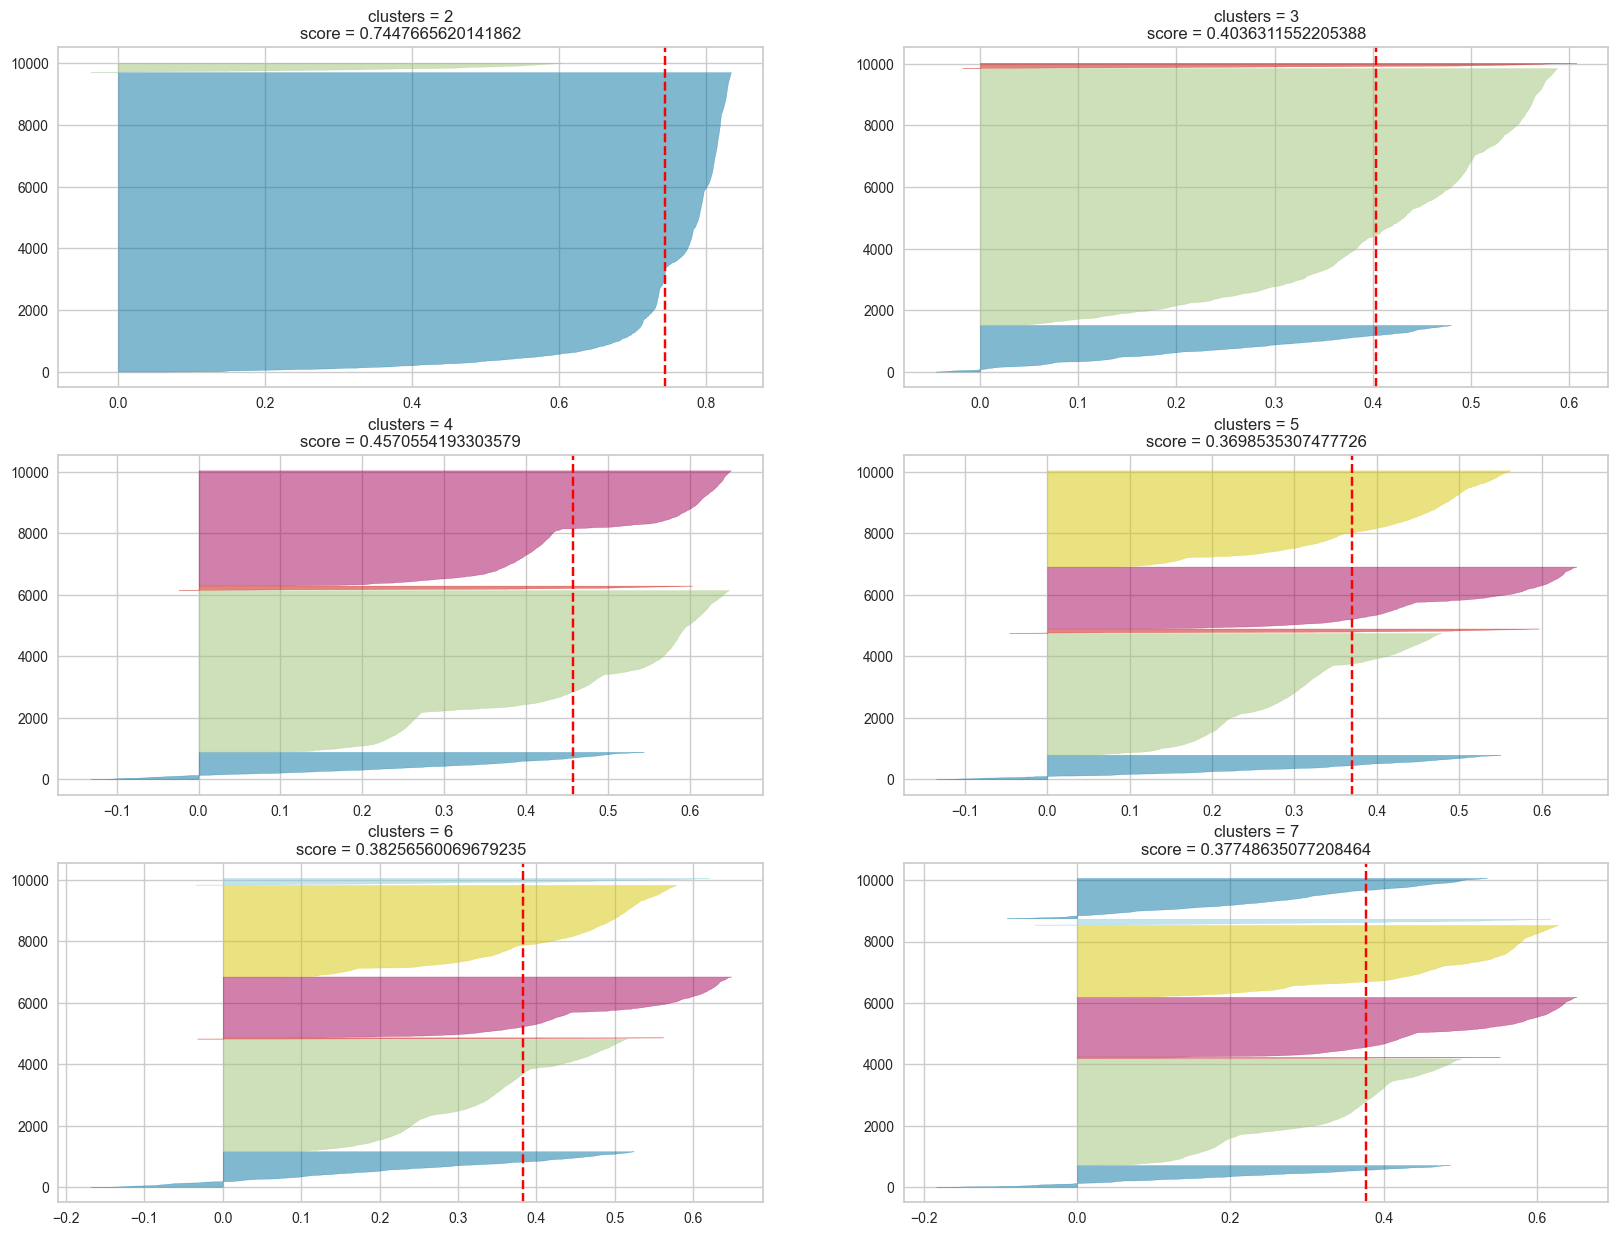

In [7]:
initRange=2
endRange=8

fig, ax = plt.subplots(3, 2, figsize=(20,15))
for nCluster in range(initRange, endRange):
    km = KMeans(n_clusters=nCluster, random_state=42)
    q, mod = divmod(nCluster, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_sample_10)
    ax[q-1][mod].set_title(f"clusters = {nCluster}\nscore = {visualizer.silhouette_score_}") 

### Testando sample de 10000 linhas normalizado

In [8]:
normalizer = MinMaxScaler()
df_sample_10_normalized = normalizer.fit_transform(df_sample_10)

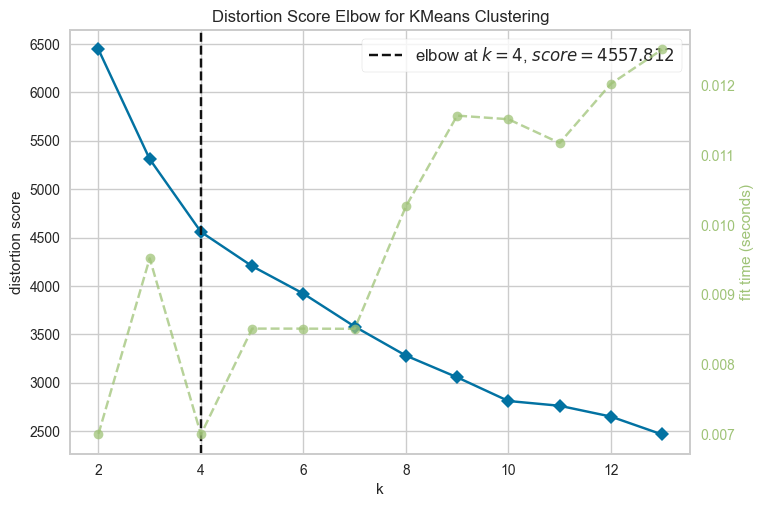

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 14))
visualizer.fit(df_sample_10_normalized)
visualizer.show()

Text(0.5, 1.0, 'clusters normalizado = 4\nscore = 0.26050422897832276')

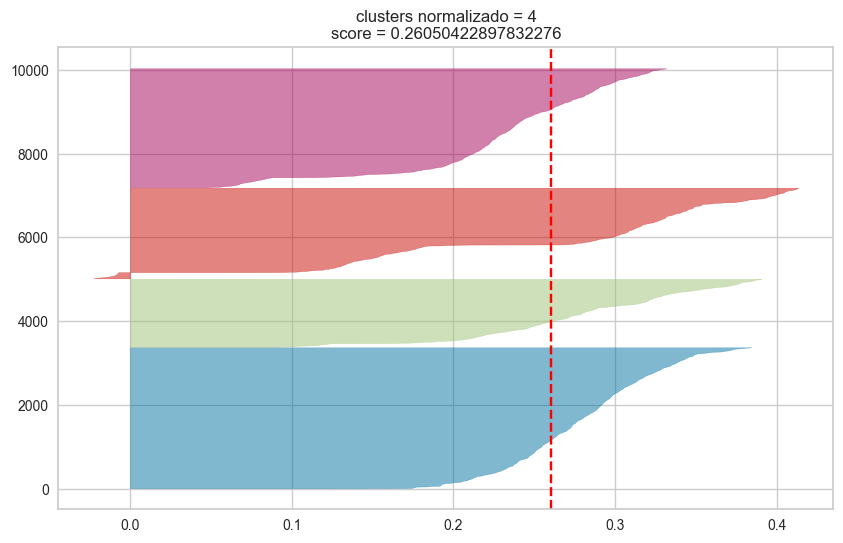

In [10]:
nCluster = 4
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

km = KMeans(n_clusters=nCluster, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax1)
visualizer.fit(df_sample_10_normalized)
ax1.set_title(f"clusters normalizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

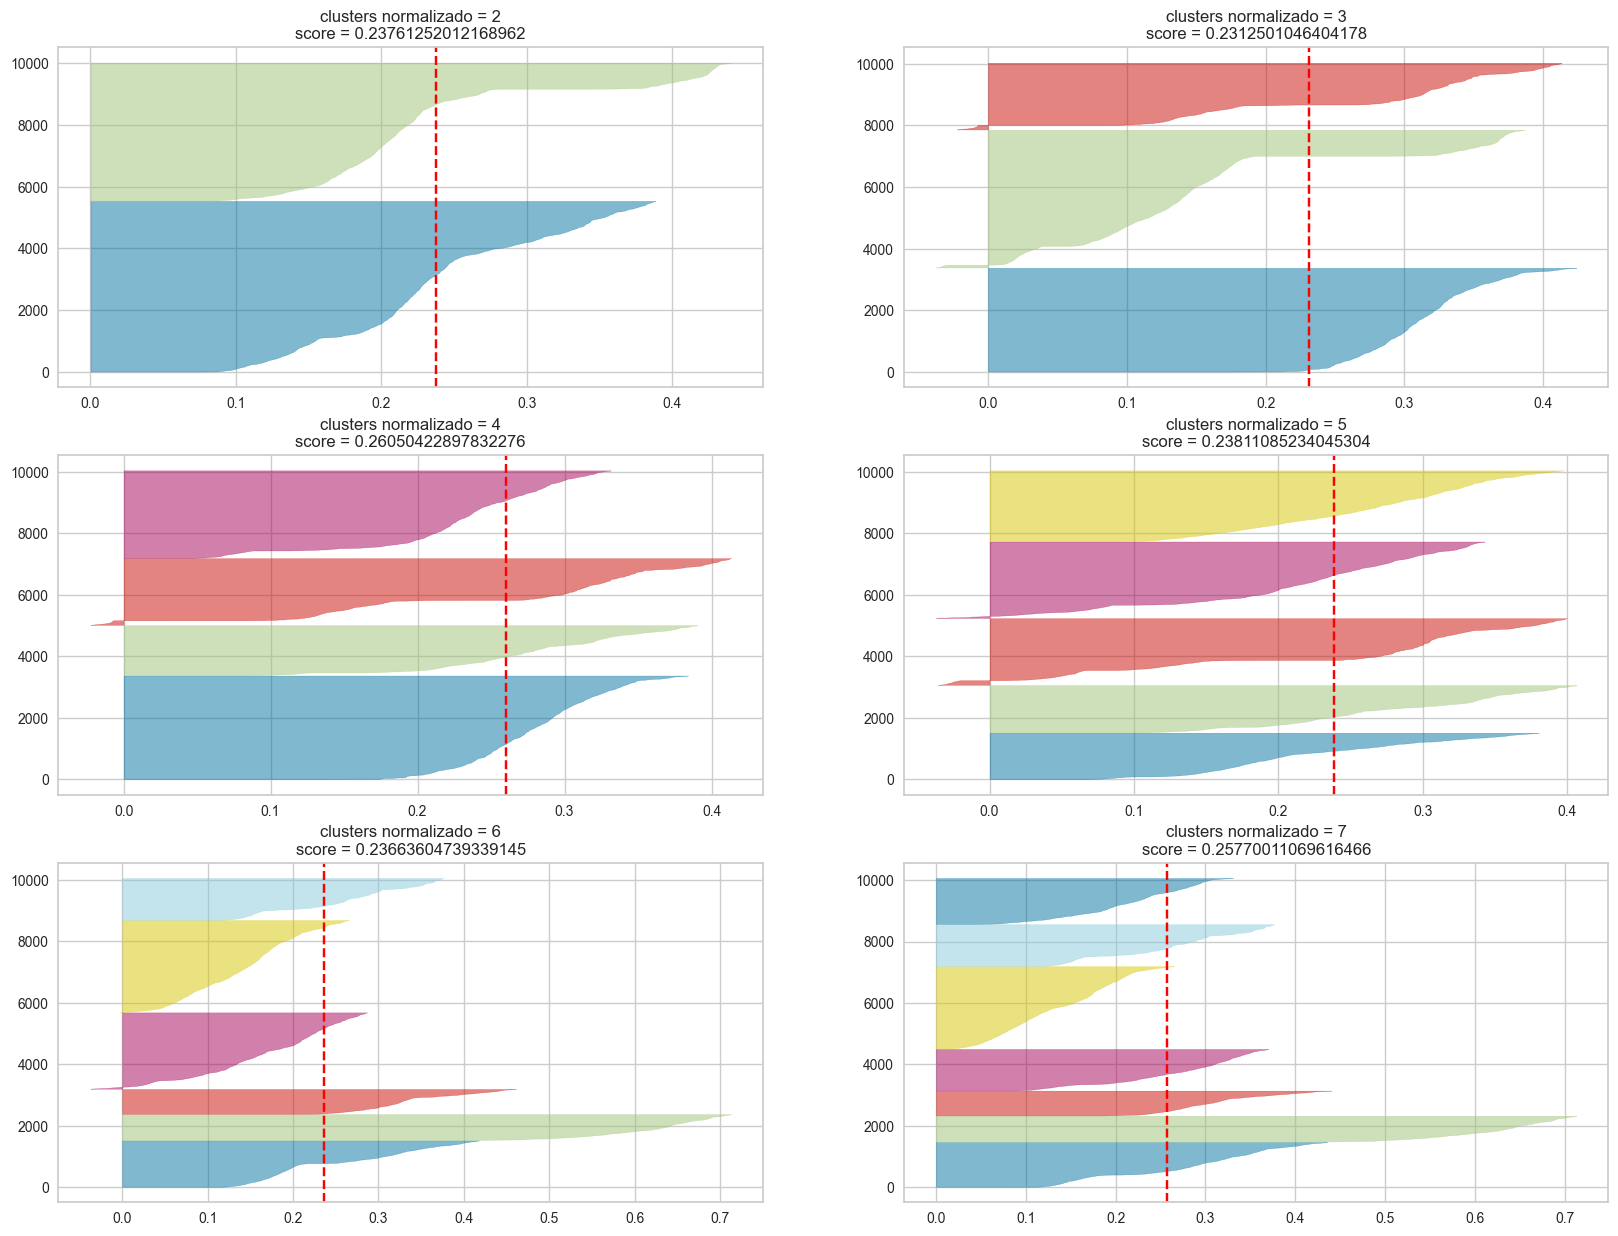

In [11]:
initRange=2
endRange=8

fig, ax = plt.subplots(3, 2, figsize=(20,15))
for nCluster in range(initRange, endRange):
    km = KMeans(n_clusters=nCluster, random_state=42)
    q, mod = divmod(nCluster, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_sample_10_normalized)
    ax[q-1][mod].set_title(f"clusters normalizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

### Testando com sample de 10000 linhas padronizado

In [12]:
scaler = StandardScaler()
df_sample_10_standardized = scaler.fit_transform(df_sample_10)

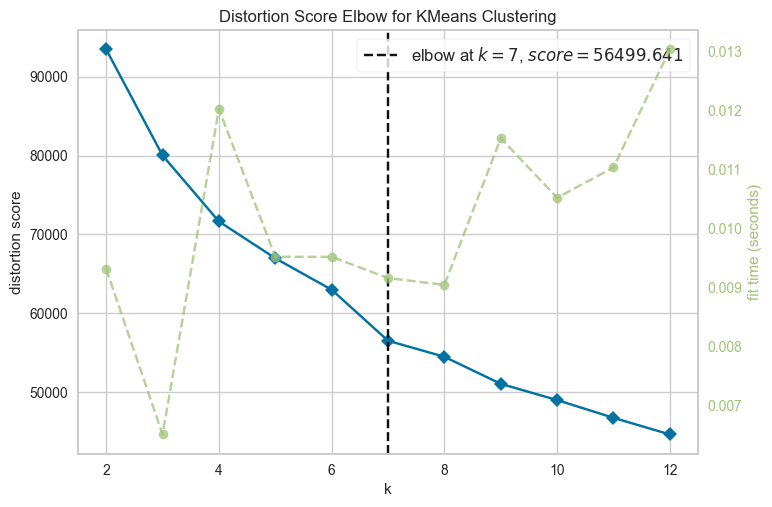

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 13))
visualizer.fit(df_sample_10_standardized)
visualizer.show()

Text(0.5, 1.0, 'clusters padronizado = 7\nscore = 0.21589744324476706')

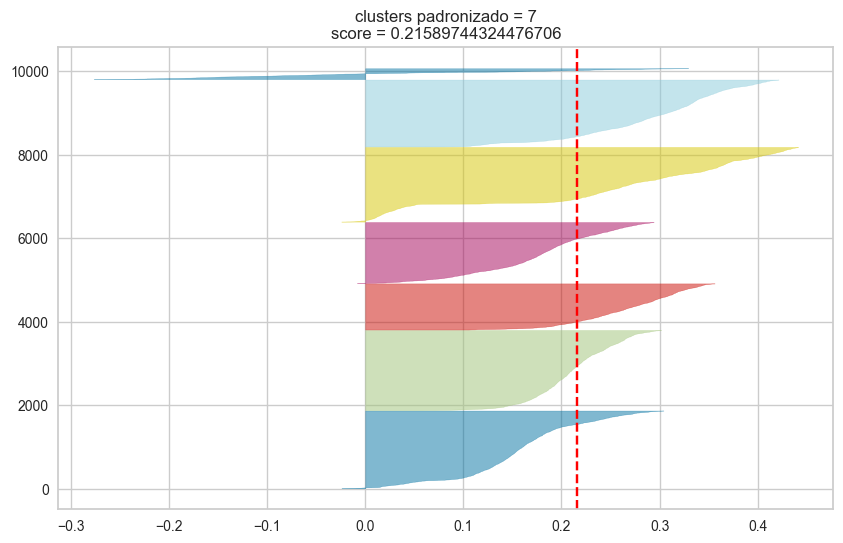

In [14]:
nCluster = 7
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

km = KMeans(n_clusters=nCluster, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax1)
visualizer.fit(df_sample_10_standardized)
ax1.set_title(f"clusters padronizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

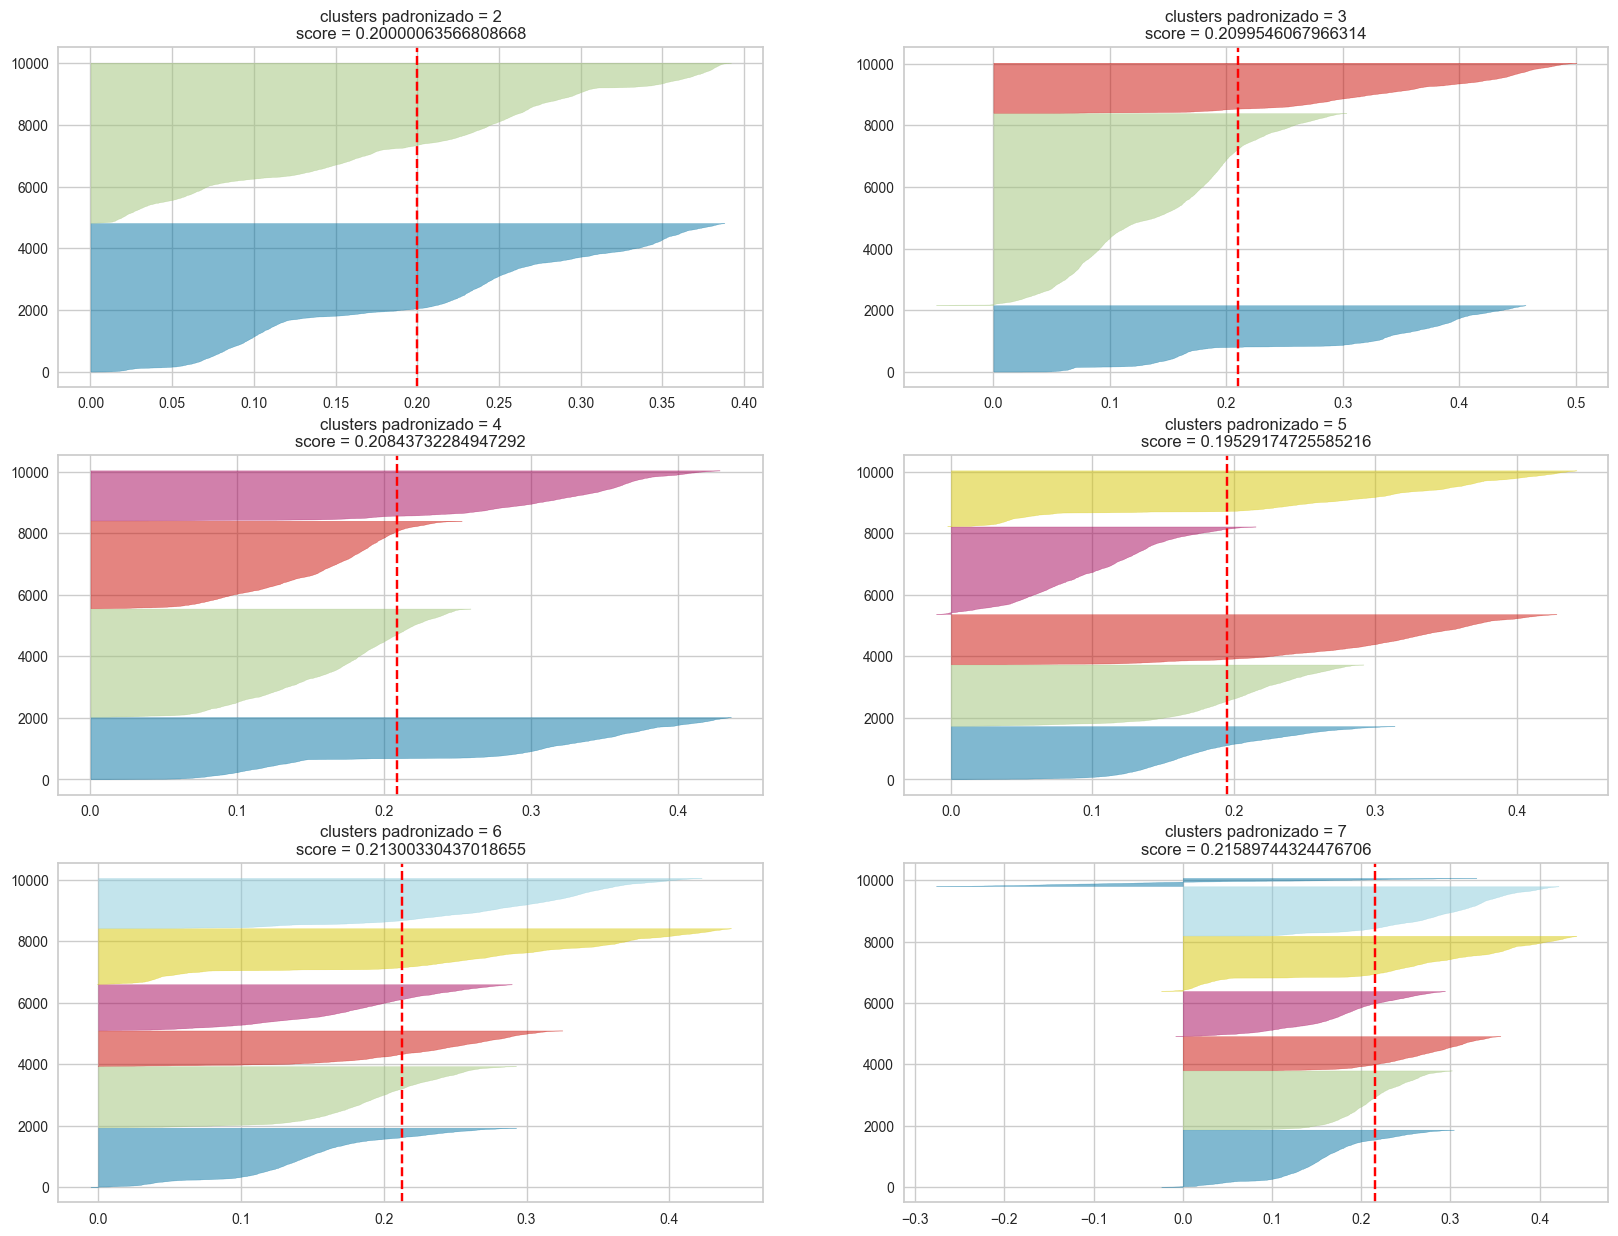

In [15]:
initRange=2
endRange=8

fig, ax = plt.subplots(3, 2, figsize=(20,15))
for nCluster in range(initRange, endRange):
    km = KMeans(n_clusters=nCluster, random_state=42)
    q, mod = divmod(nCluster, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_sample_10_standardized)
    ax[q-1][mod].set_title(f"clusters padronizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

## Seguindo com o dataframe normalizado. Buscando melhor número de clusters

In [16]:
normalizer = MinMaxScaler()
df_nparray_normalized = normalizer.fit_transform(df_cluster)

df_normalized = pd.DataFrame({f'{df_cluster.columns[i]}': df_nparray_normalized[:,i] for i in range(df_nparray_normalized.shape[1])})
df_normalized

comdate_diff  freight_value     price  days_since_year_start  \
0          0.661538       0.113454  0.042740               0.000000   
1          0.061538       0.054457  0.038418               0.793296   
2          0.230769       0.018990  0.002048               0.184358   
3          0.753846       0.034417  0.003534               0.000000   
4          0.600000       0.055092  0.014657               0.000000   
...             ...            ...       ...                    ...   
87849      0.369231       0.050967  0.007990               1.000000   
87850      0.538462       0.034564  0.016885               0.251397   
87851      0.600000       0.046475  0.005316               0.251397   
87852      0.169231       0.053871  0.102141               0.913408   
87853      0.400000       0.018990  0.001899               1.000000   

       days_since_month_start  year     month  day_of_month  day_of_week  \
0                    0.000000   1.0  0.000000      0.000000     0.000000   
1                    0.458333   0.5  0.818182      0.458333     0.500000   
2                    0.291667   1.0  0.181818      0.291667     0.500000   
3                    0.000000   1.0  0.000000      0.000000     0.000000   
4                    0.000000   1.0  0.000000      0.000000     0.000000   
...                       ...   ...       ...           ...          ...   
87849                1.000000   0.5  1.000000      1.000000     0.000000   
87850                0.000000   1.0  0.272727      0.000000     1.000000   
87851                0.000000   1.0  0.272727      0.000000     1.000000   
87852                0.958333   0.5  0.909091      0.958333     0.666667   
87853                1.000000   0.5  1.000000      1.000000     0.000000   

       filtered_category_coded  commercial_date_coded  time_window_order_coded  
0                     1.000000               1.000000                      0.5  
1                     0.428571               0.777778                      0.5  
2                     0.571429               0.111111                      0.0  
3                     0.214286               1.000000                      0.5  
4                     0.642857               1.000000                      0.5  
...                        ...                    ...                      ...  
87849                 1.000000               0.666667                      0.0  
87850                 0.428571               0.888889                      0.5  
87851                 0.142857               0.888889                      0.5  
87852                 0.857143               0.000000                      0.0  
87853                 0.785714               0.666667                      1.0  

[87854 rows x 12 columns]

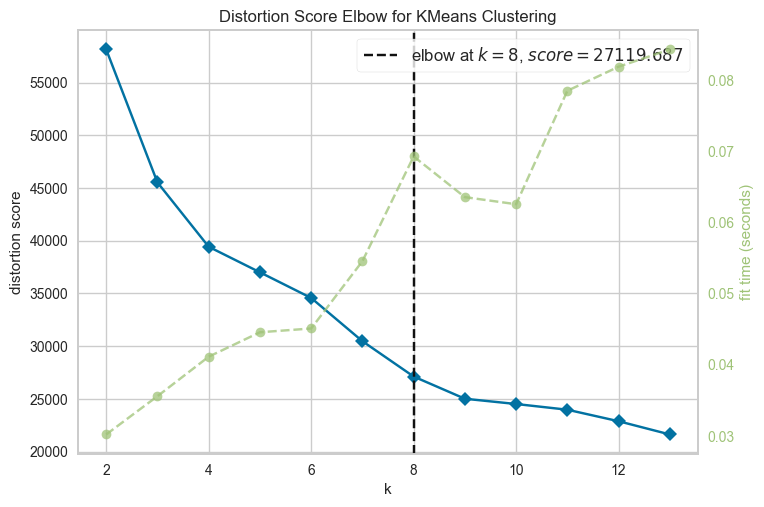

Text(0.5, 1.0, 'clusters normalizado = 8\nscore = 0.2991040839168496')

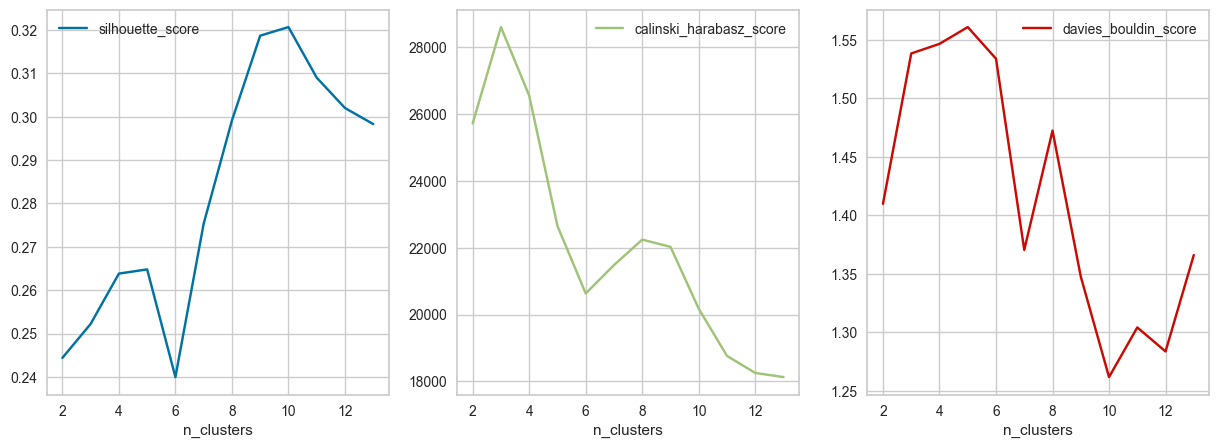

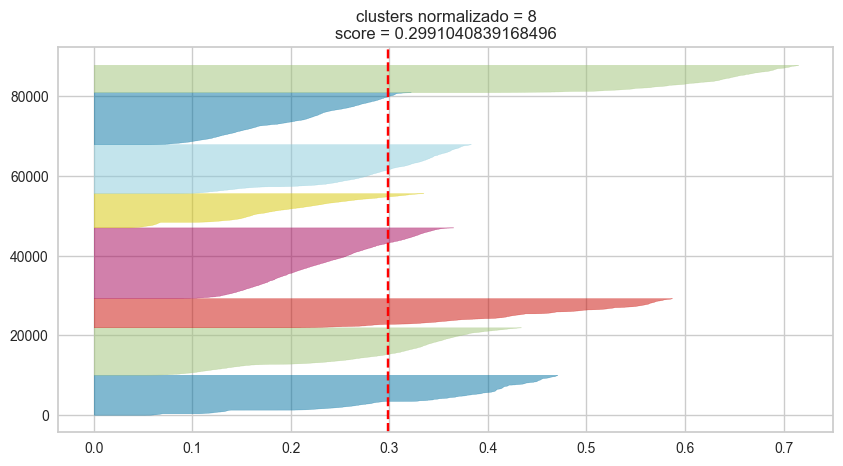

In [17]:
random = 42
initRange = 2
endRange = 14
df_cluster = df_normalized
# df = df_normalized.sample(10000, random_state=random)

# grafico de cotovelo
km = KMeans(random_state=random)
visualizer = KElbowVisualizer(km, k=(initRange, endRange))
visualizer.fit(df_cluster)
visualizer.show()

# graficos de score. Silhoueta, Calinski Harabasz, Davies Bouldin 
fitted_kmeans = {}
labels_kmeans = {}
df_scores = []
for n_clusters in np.arange(initRange, endRange):
    tmp_scores = {}
    tmp_scores["n_clusters"] = n_clusters
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random)
    labels_clusters = kmeans.fit_predict(df_cluster)
    
    fitted_kmeans[n_clusters] = kmeans
    labels_kmeans[n_clusters] = labels_clusters
    
    silhouette = silhouette_score(df_cluster, labels_clusters)
    tmp_scores["silhouette_score"] = silhouette
    ch = calinski_harabasz_score(df_cluster, labels_clusters)
    tmp_scores["calinski_harabasz_score"] = ch
    db = davies_bouldin_score(df_cluster, labels_clusters)
    tmp_scores["davies_bouldin_score"] = db
                
    df_scores.append(tmp_scores)

df_scores = pd.DataFrame(df_scores)
df_scores.set_index("n_clusters", inplace=True)
df_scores.plot(subplots=True, layout=(1,3), figsize=(15, 5))

# Grafico de silhoueta com 8 clusters
nCluster = 8
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
km = KMeans(n_clusters=nCluster, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax1)
visualizer.fit(df_cluster)
ax1.set_title(f"clusters normalizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

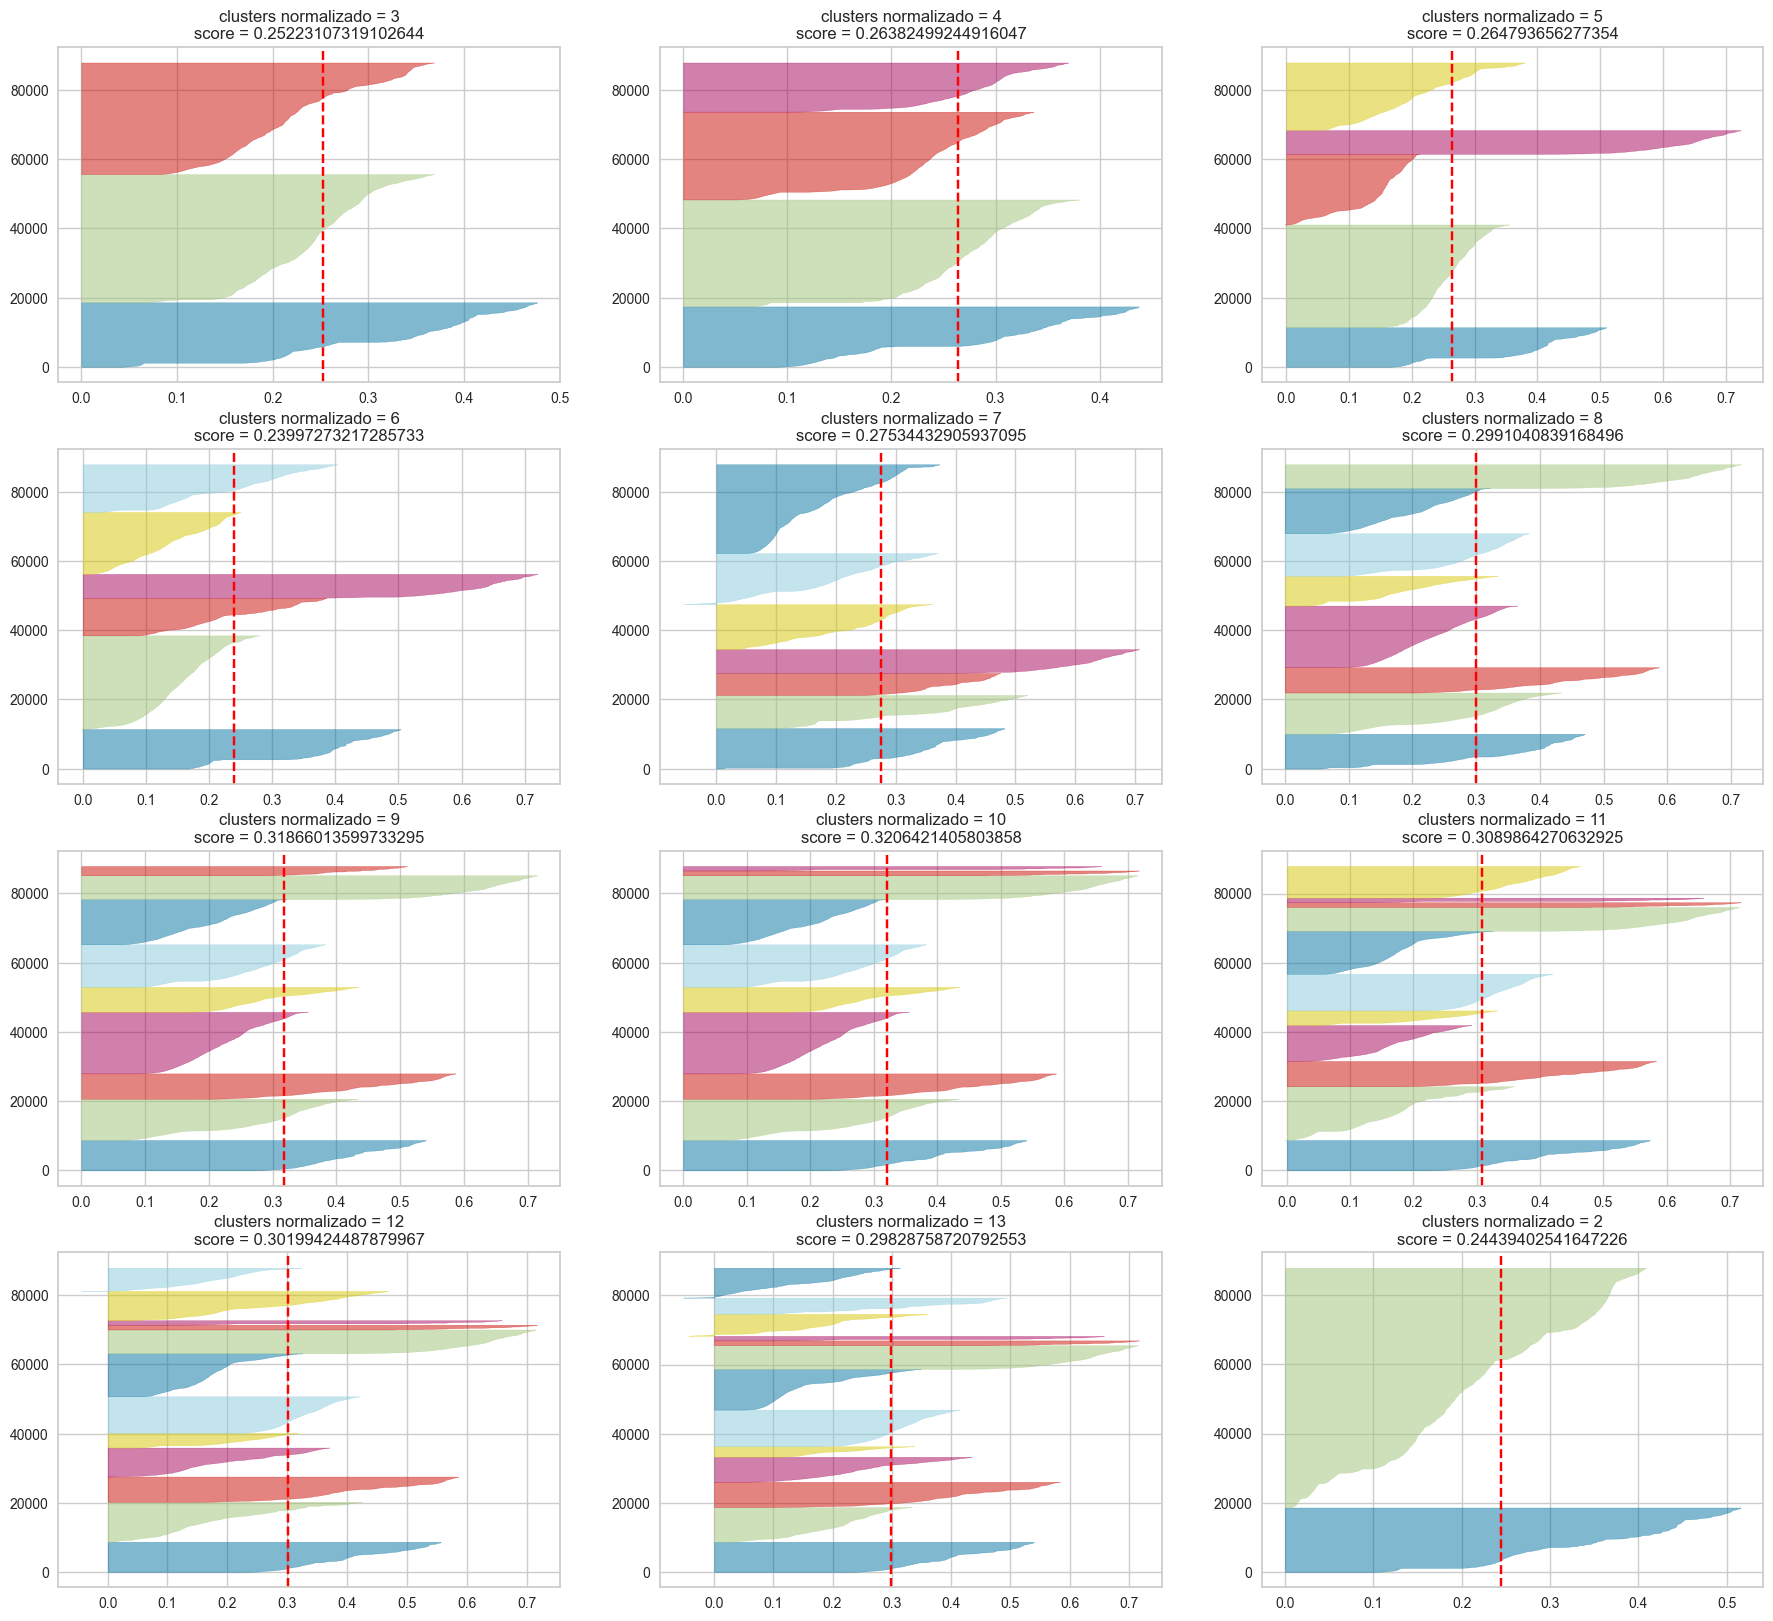

In [32]:
initRange=2
endRange=14

fig, ax = plt.subplots(4, 3, figsize=(22,20))
for nCluster in range(initRange, endRange):
    km = KMeans(n_clusters=nCluster, random_state=42)
    q, mod = divmod(nCluster, 3)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_normalized)
    ax[q-1][mod].set_title(f"clusters normalizado = {nCluster}\nscore = {visualizer.silhouette_score_}") 

## Encontrado os números 4 e 8 para clusters

## Clusterizando

### KMeans
### Utilizando 4 e 8 clusters 

In [74]:
n_clusters = 4
kmeans_model = KMeans(n_clusters, random_state=42)
clusters = kmeans_model.fit_predict(df_normalized)
df_kmeans = pd.DataFrame(clusters)
df_normalized.insert(df_normalized.shape[1], f'kmeans_{n_clusters}', df_kmeans)
df_normalized

n_clusters = 8
kmeans_model = KMeans(n_clusters, random_state=42)
clusters = kmeans_model.fit_predict(df_normalized)
df_kmeans = pd.DataFrame(clusters)
df_normalized.insert(df_normalized.shape[1], f'kmeans_{n_clusters}', df_kmeans)
df_normalized

df_cluster["kmeans_4"] = df_normalized["kmeans_4"]
df_cluster["kmeans_8"] = df_normalized["kmeans_8"]
df_cluster

comdate_diff  freight_value   price  days_since_year_start  \
0                11          46.48  289.00                      0   
1               -28          22.31  259.90                    284   
2               -17           7.78   14.99                     66   
3                17          14.10   25.00                      0   
4                 7          22.57   99.90                      0   
...             ...            ...     ...                    ...   
87849            -8          20.88   55.00                    358   
87850             3          14.16  114.90                     90   
87851             7          19.04   37.00                     90   
87852           -21          22.07  689.00                    327   
87853            -6           7.78   13.99                    358   

       days_since_month_start  year  month  day_of_month  day_of_week  \
0                           0  2018      1             1            0   
1                          11  2017     10            12            3   
2                           7  2018      3             8            3   
3                           0  2018      1             1            0   
4                           0  2018      1             1            0   
...                       ...   ...    ...           ...          ...   
87849                      24  2017     12            25            0   
87850                       0  2018      4             1            6   
87851                       0  2018      4             1            6   
87852                      23  2017     11            24            4   
87853                      24  2017     12            25            0   

       filtered_category_coded  commercial_date_coded  \
0                           14                      9   
1                            6                      7   
2                            8                      1   
3                            3                      9   
4                            9                      9   
...                        ...                    ...   
87849                       14                      6   
87850                        6                      8   
87851                        2                      8   
87852                       12                      0   
87853                       11                      6   

       time_window_order_coded  kmeans_4  kmeans_8  
0                            1         3         1  
1                            1         1         7  
2                            0         2         6  
3                            1         3         1  
4                            1         3         1  
...                        ...       ...       ...  
87849                        0         0         0  
87850                        1         3         5  
87851                        1         3         5  
87852                        0         0         0  
87853                        2         0         0  

[87854 rows x 14 columns]

## EDA geral para decisão do número de clusters

### EDA para kmeans de 4 e 8 clusters 
### Todas as features

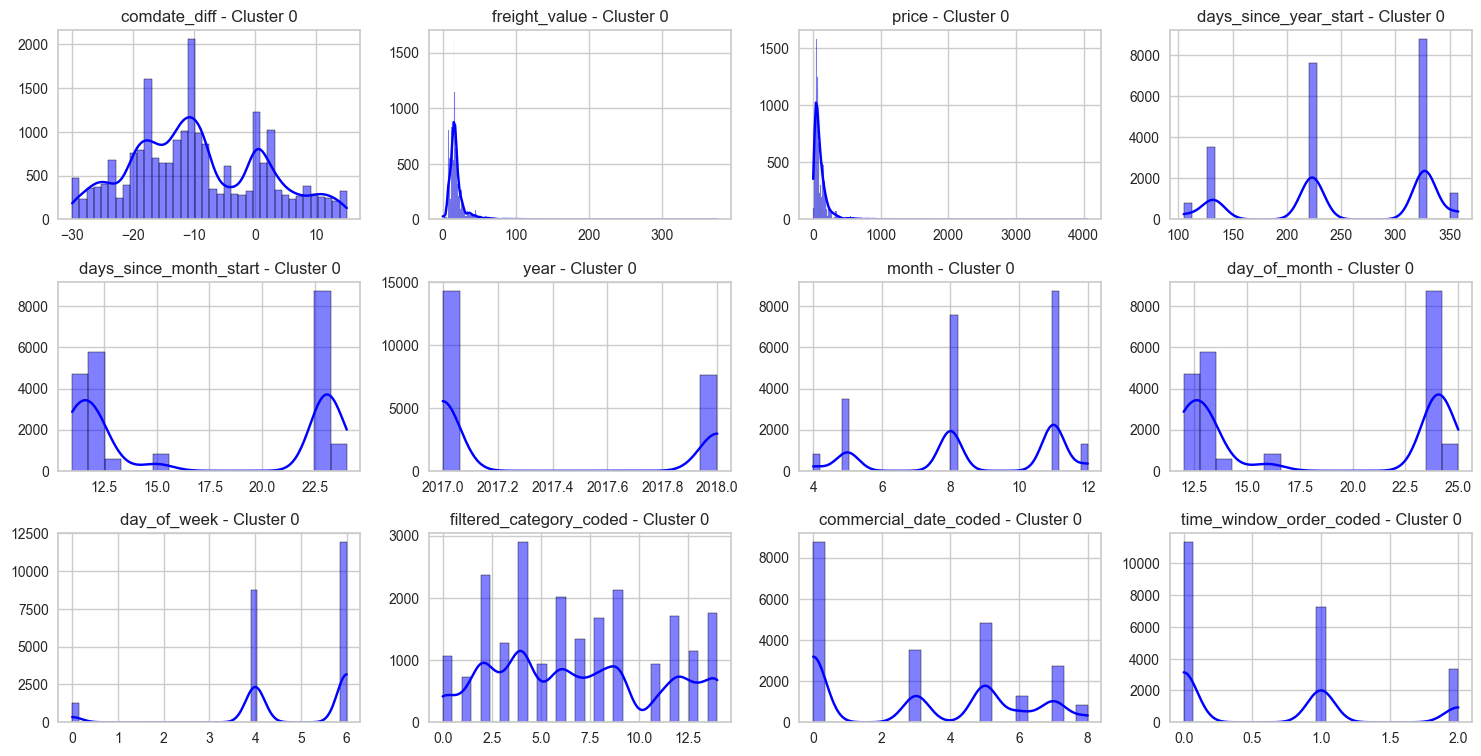

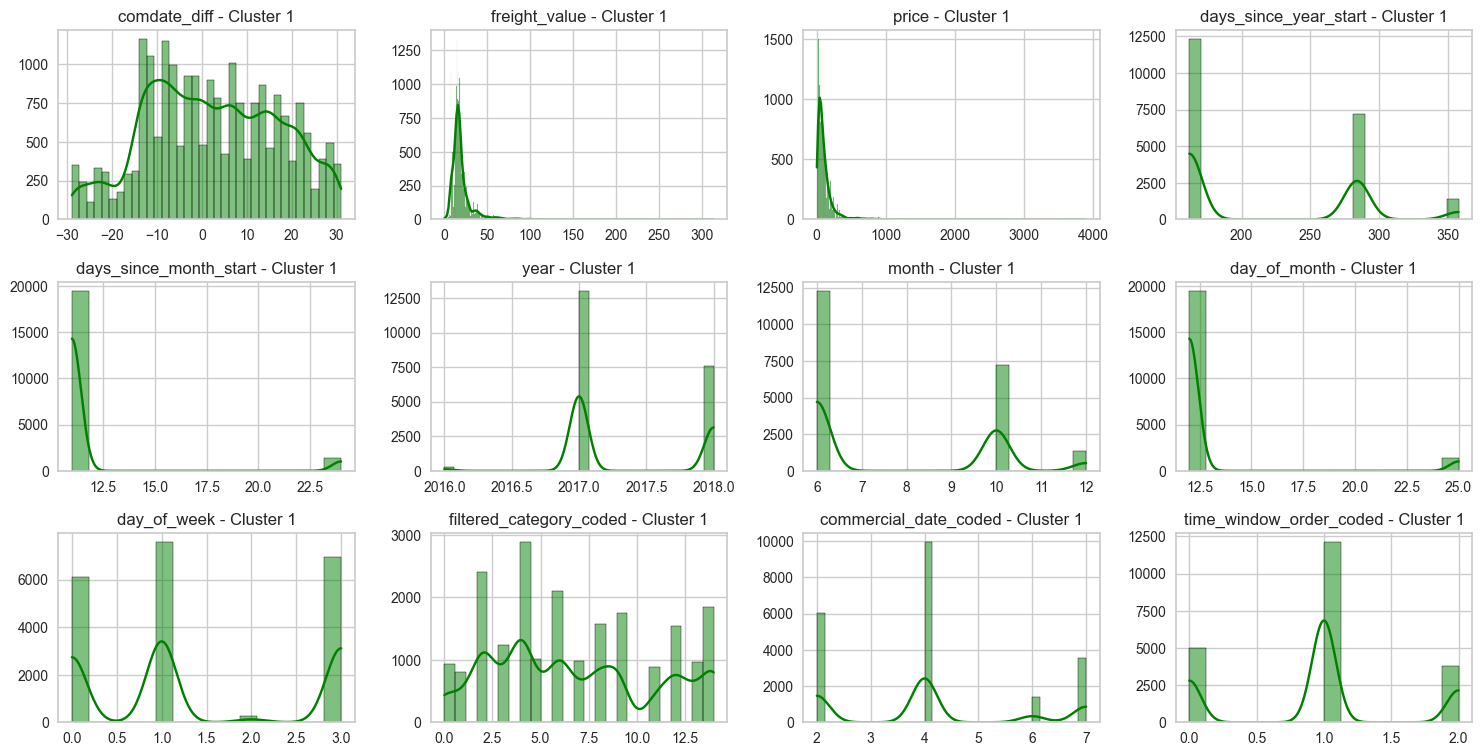

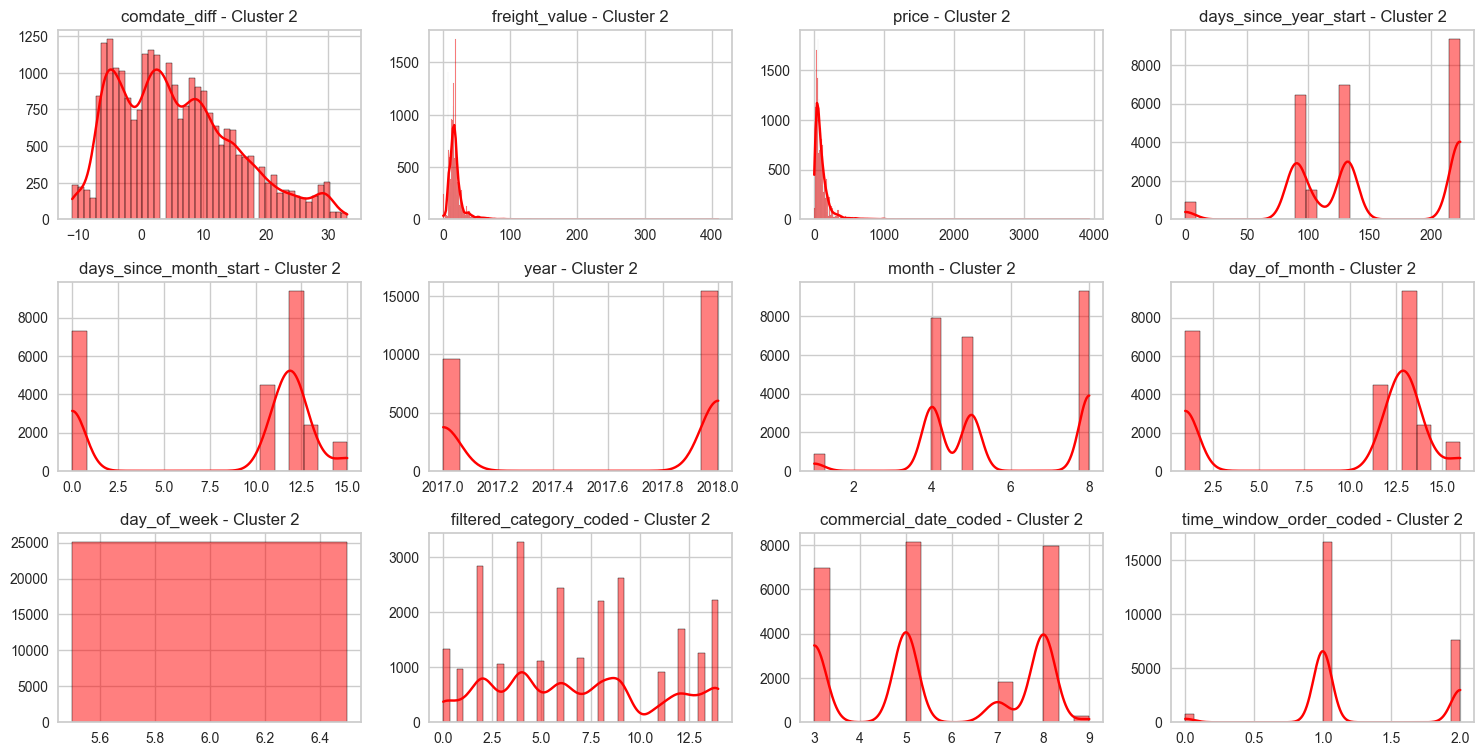

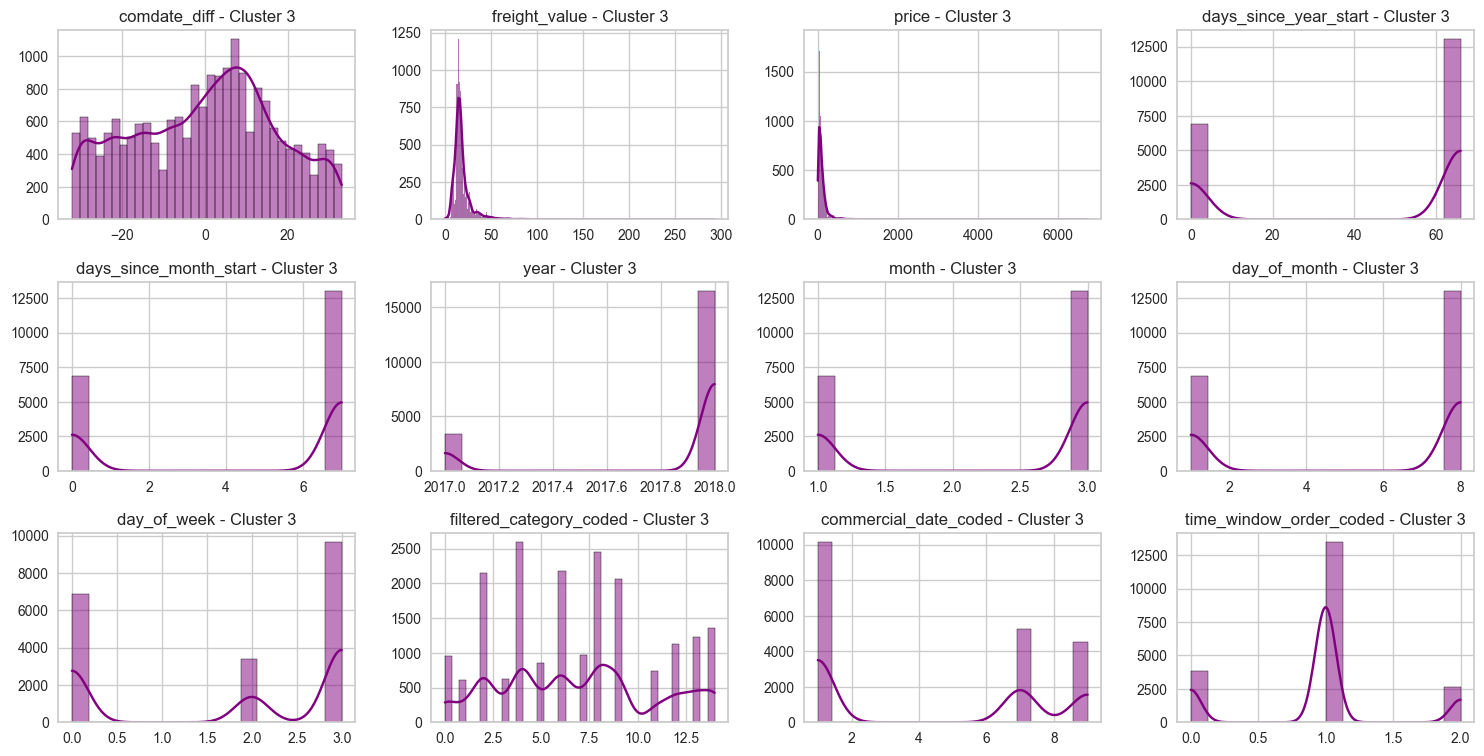

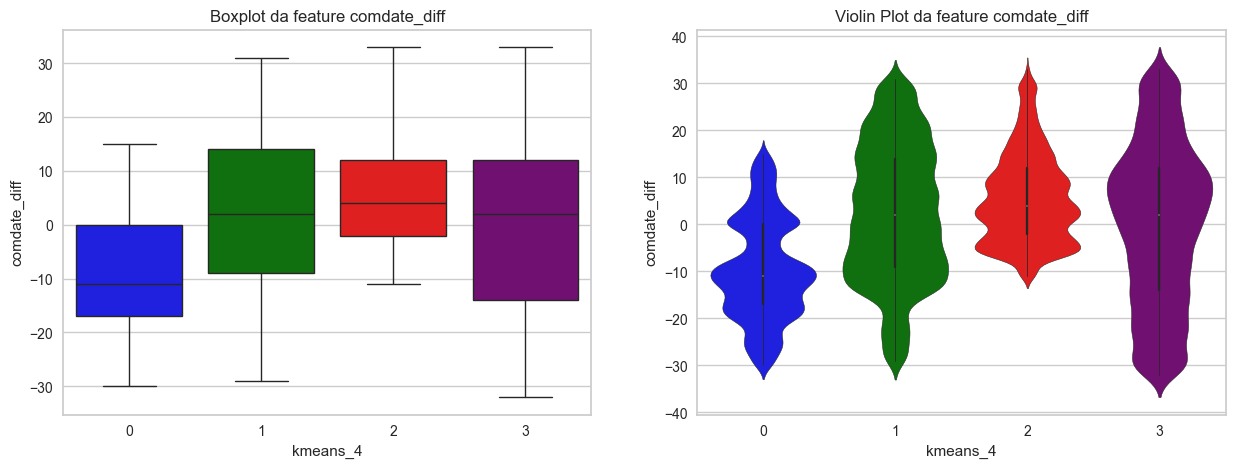

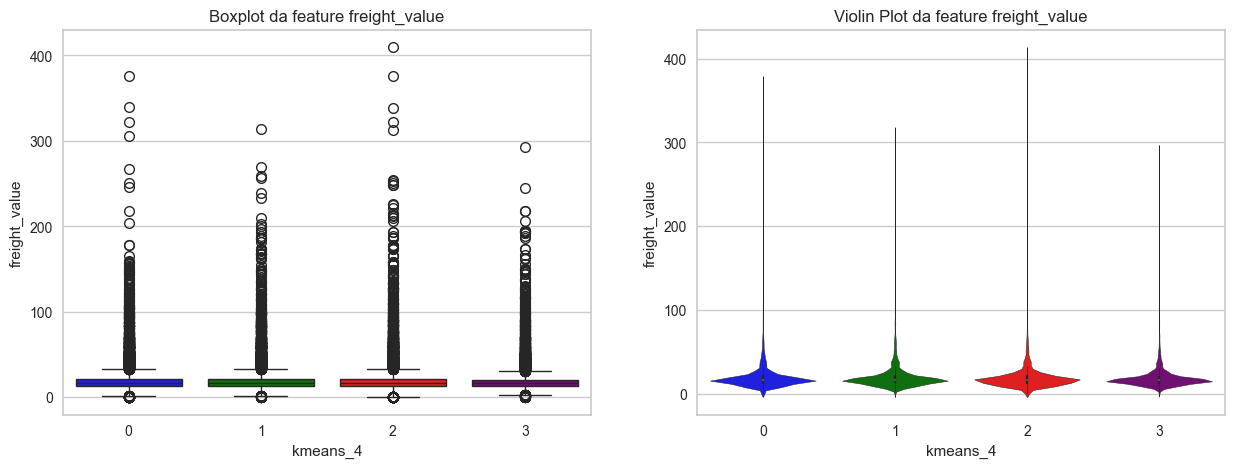

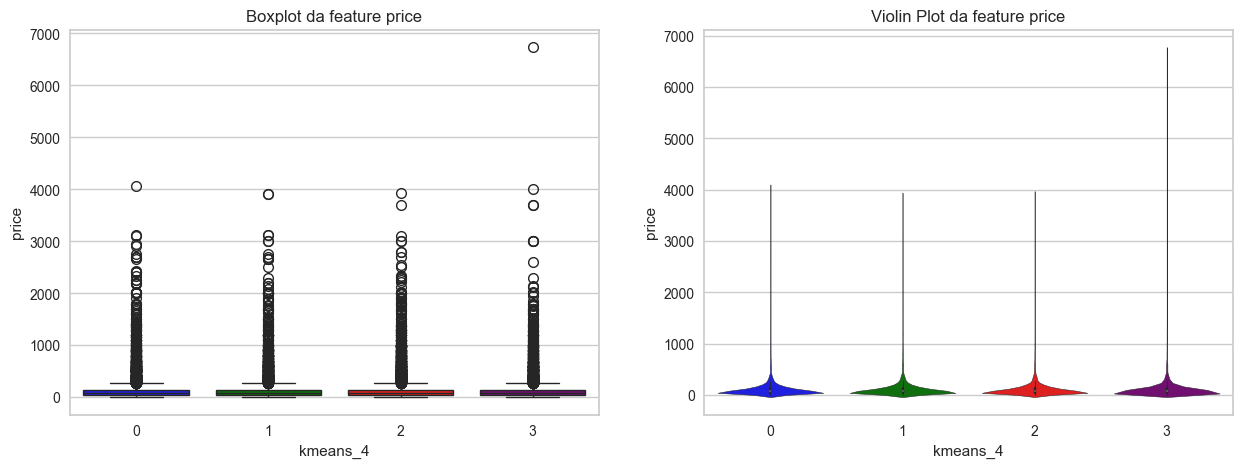

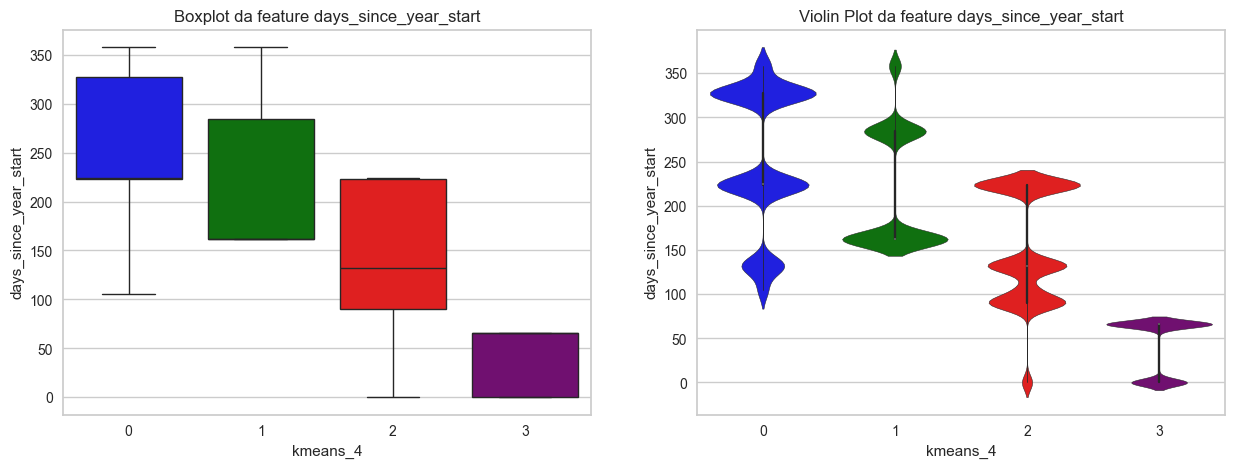

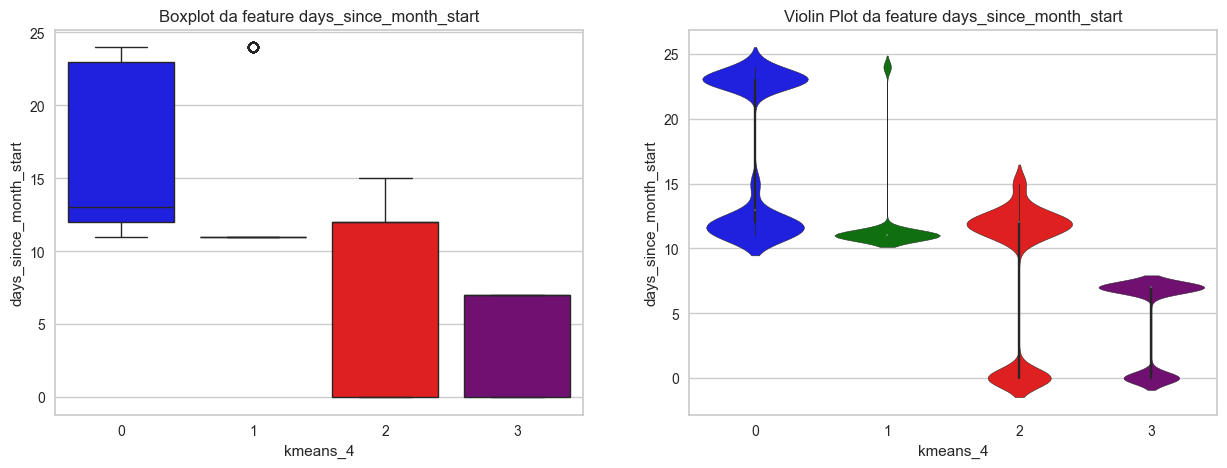

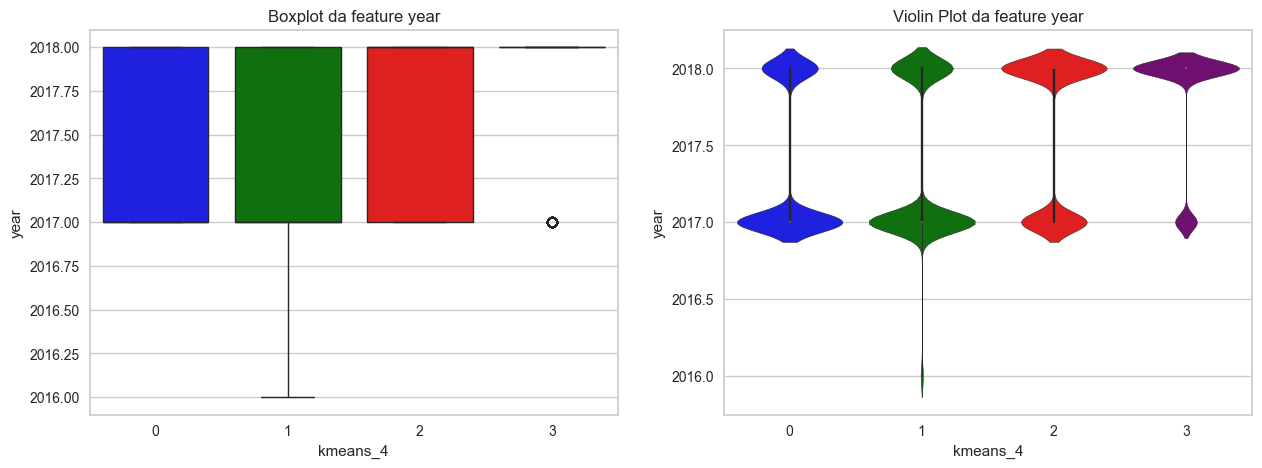

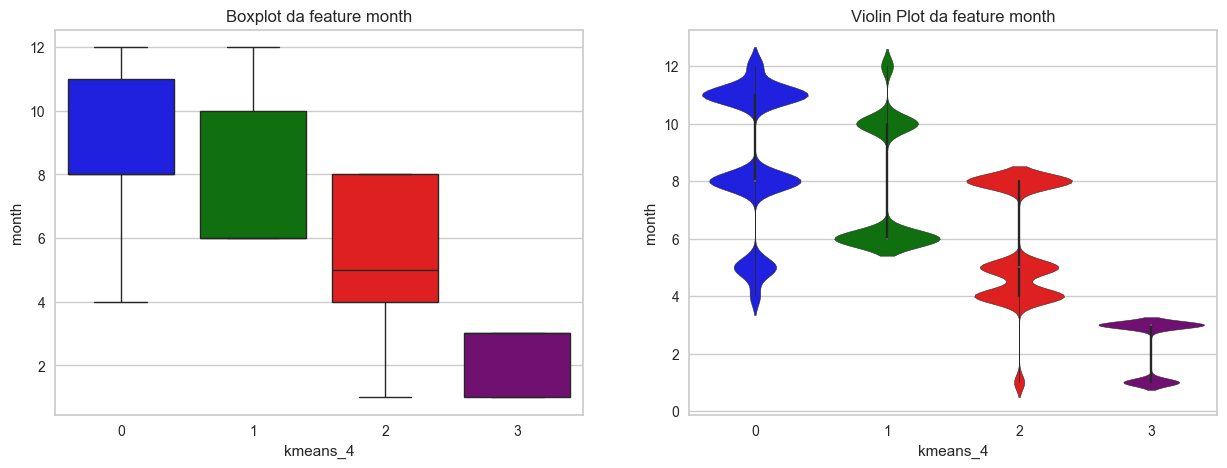

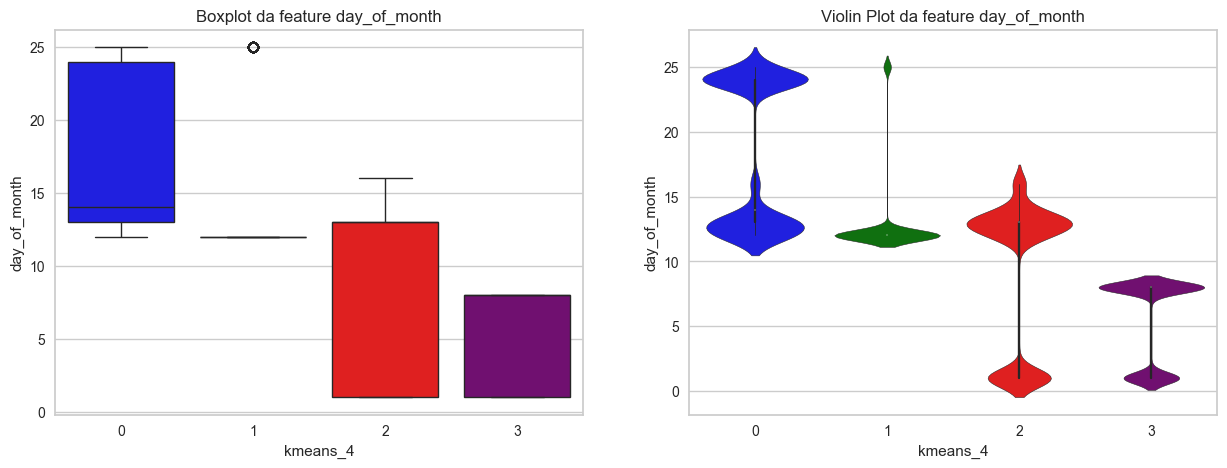

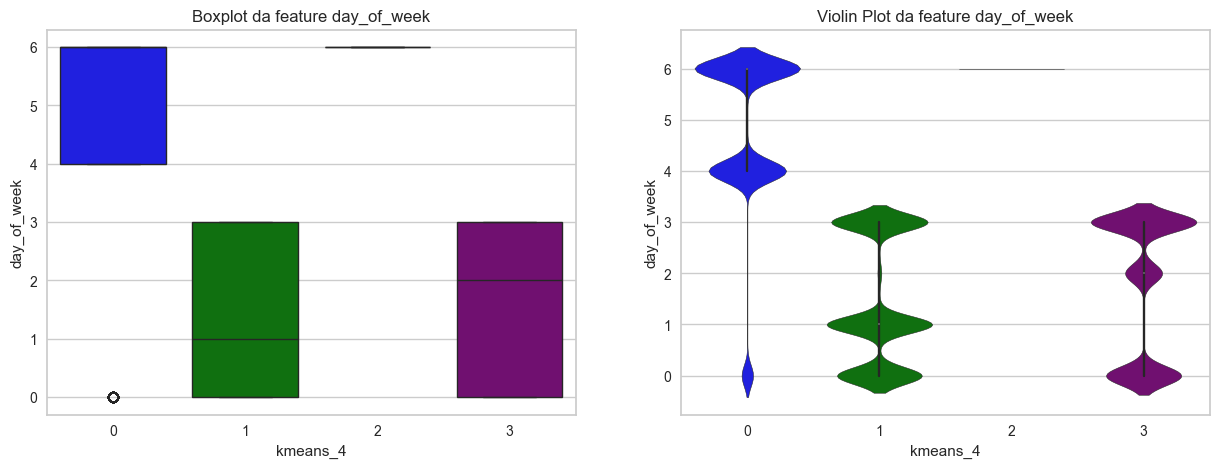

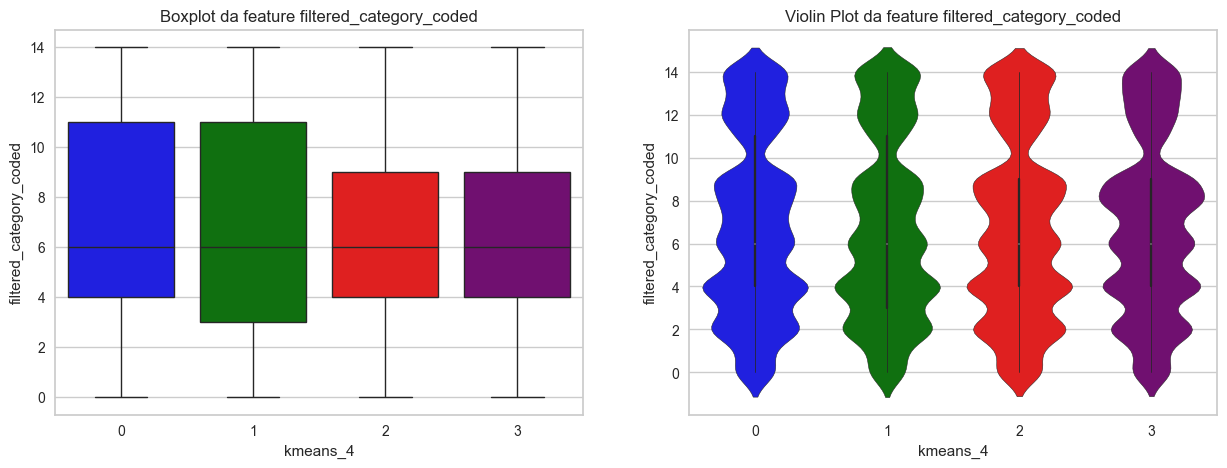

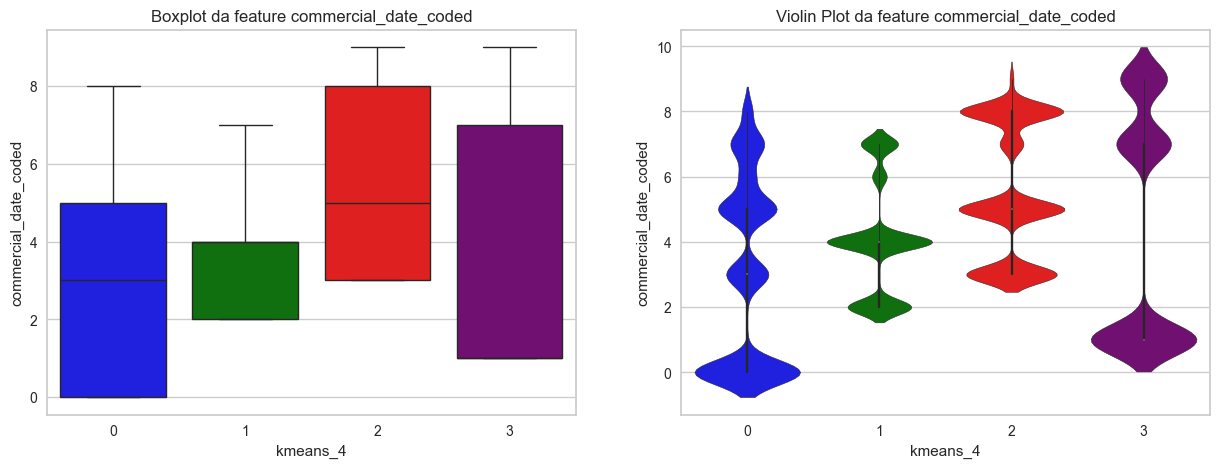

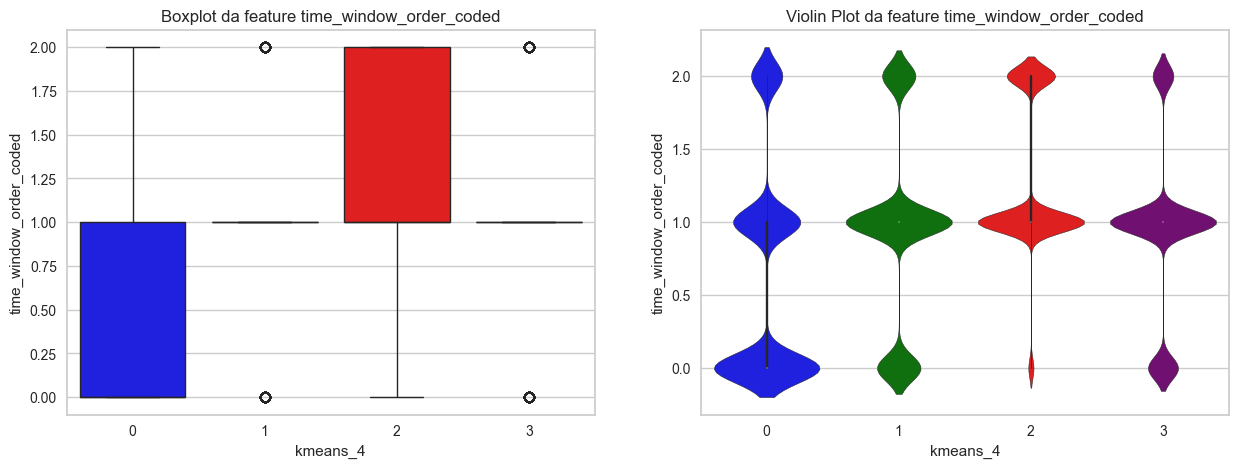

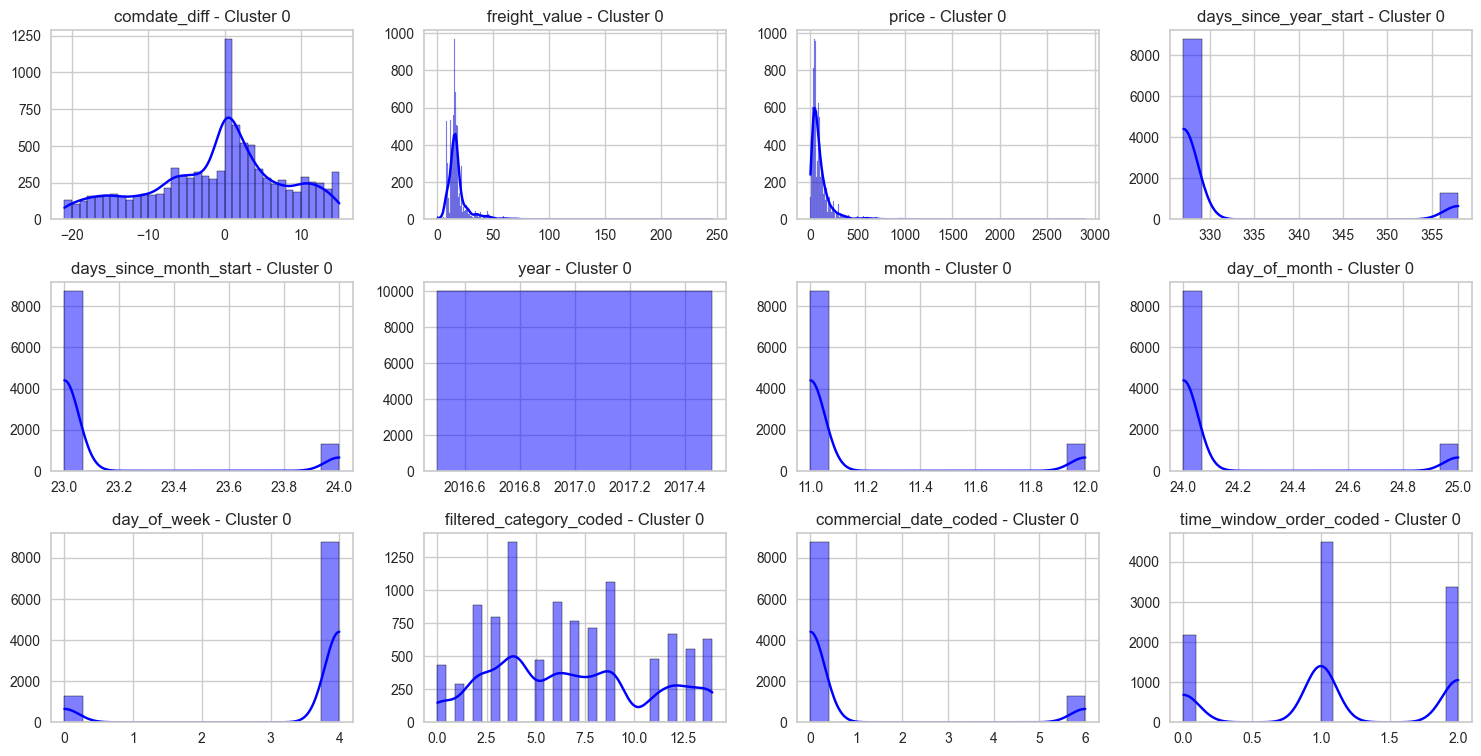

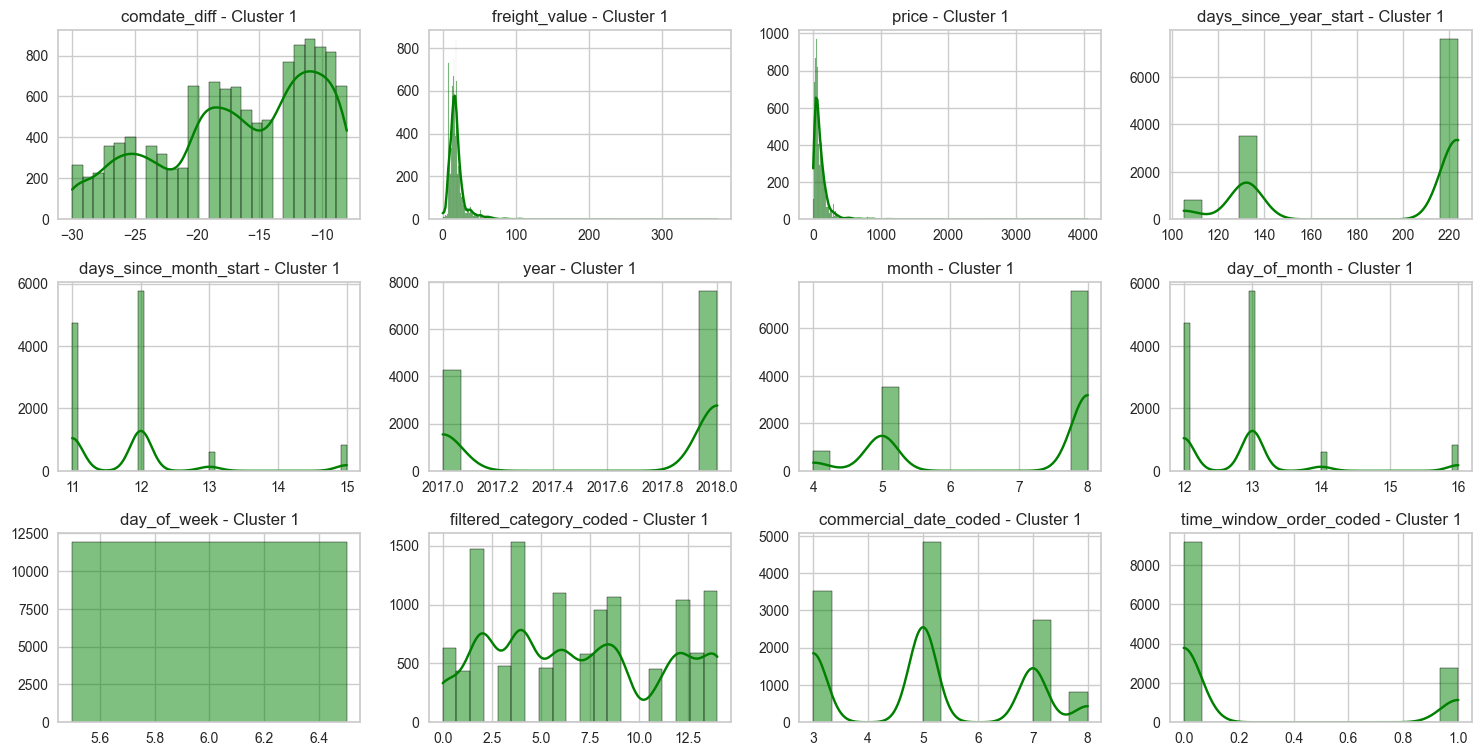

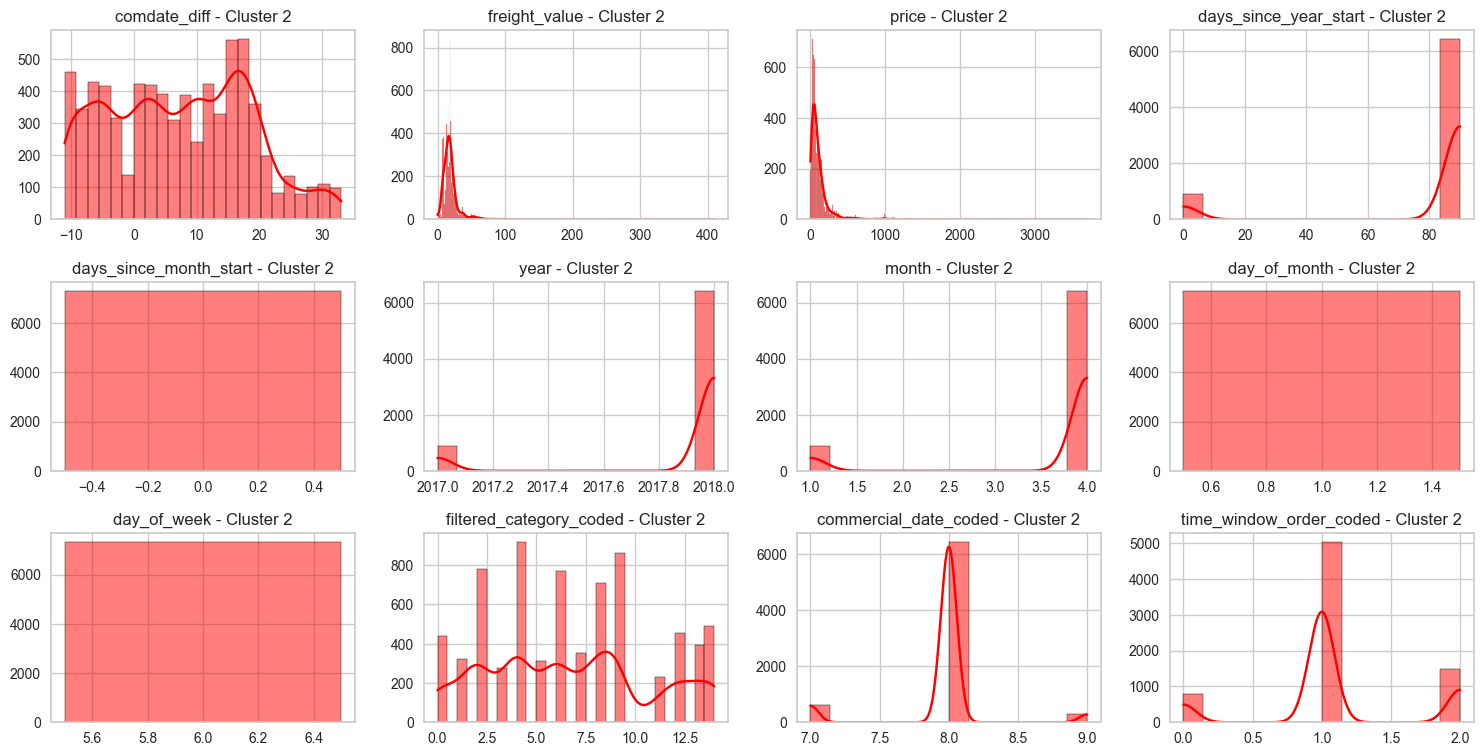

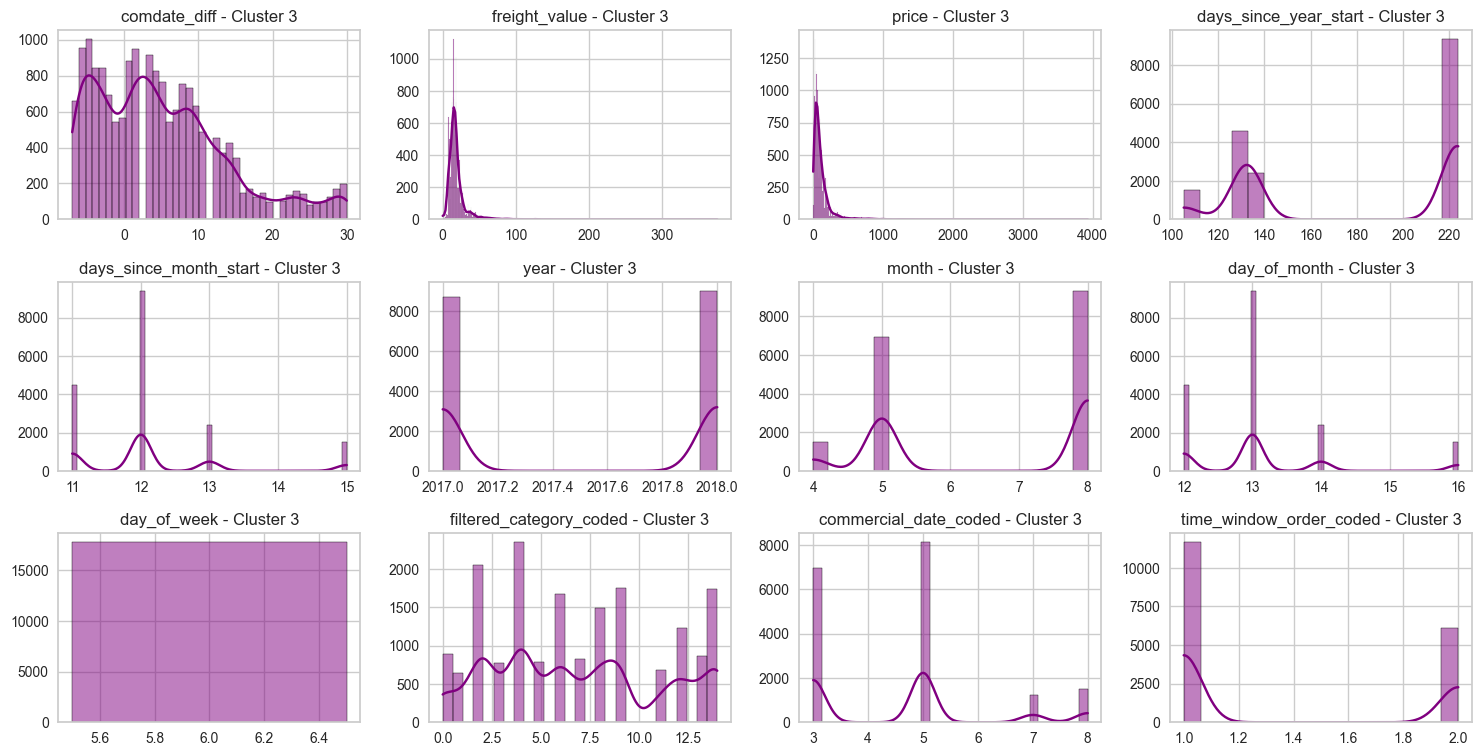

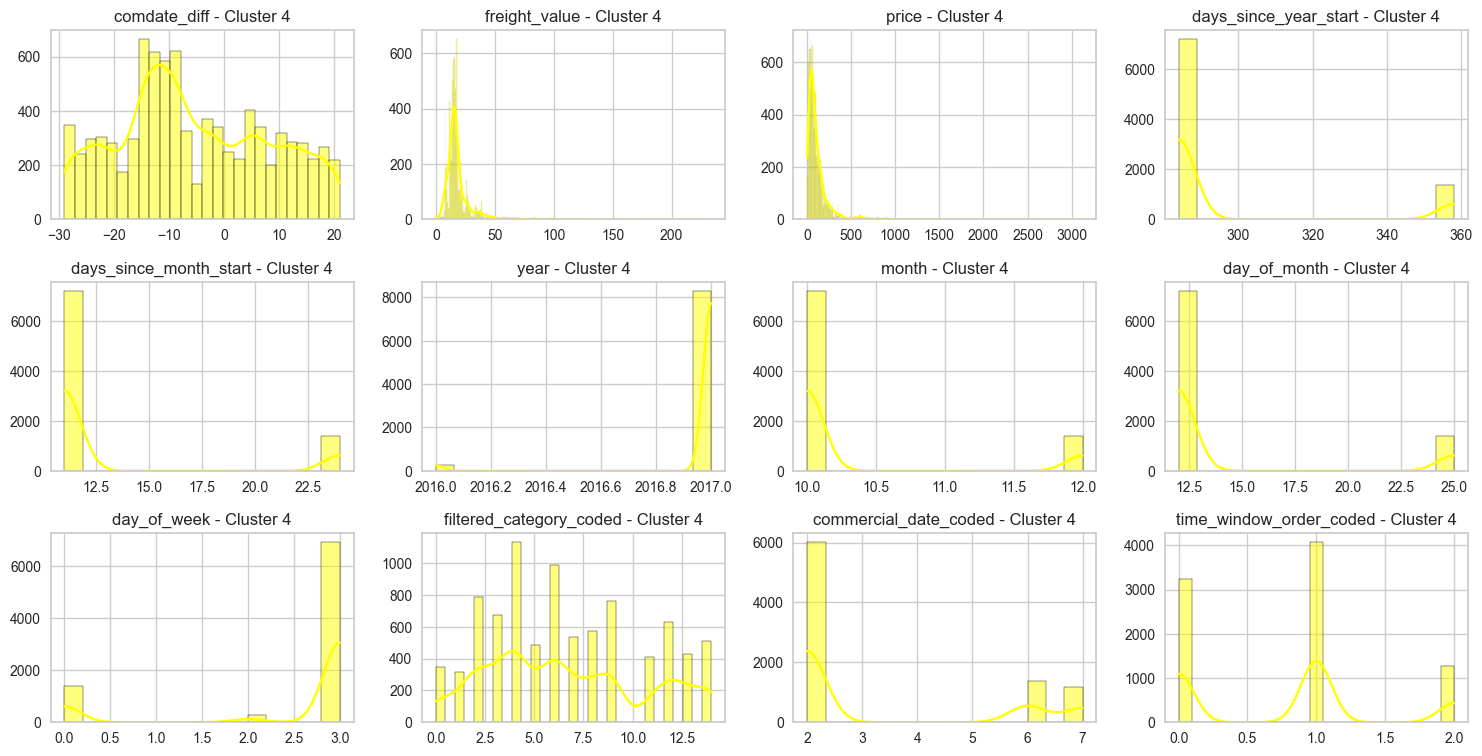

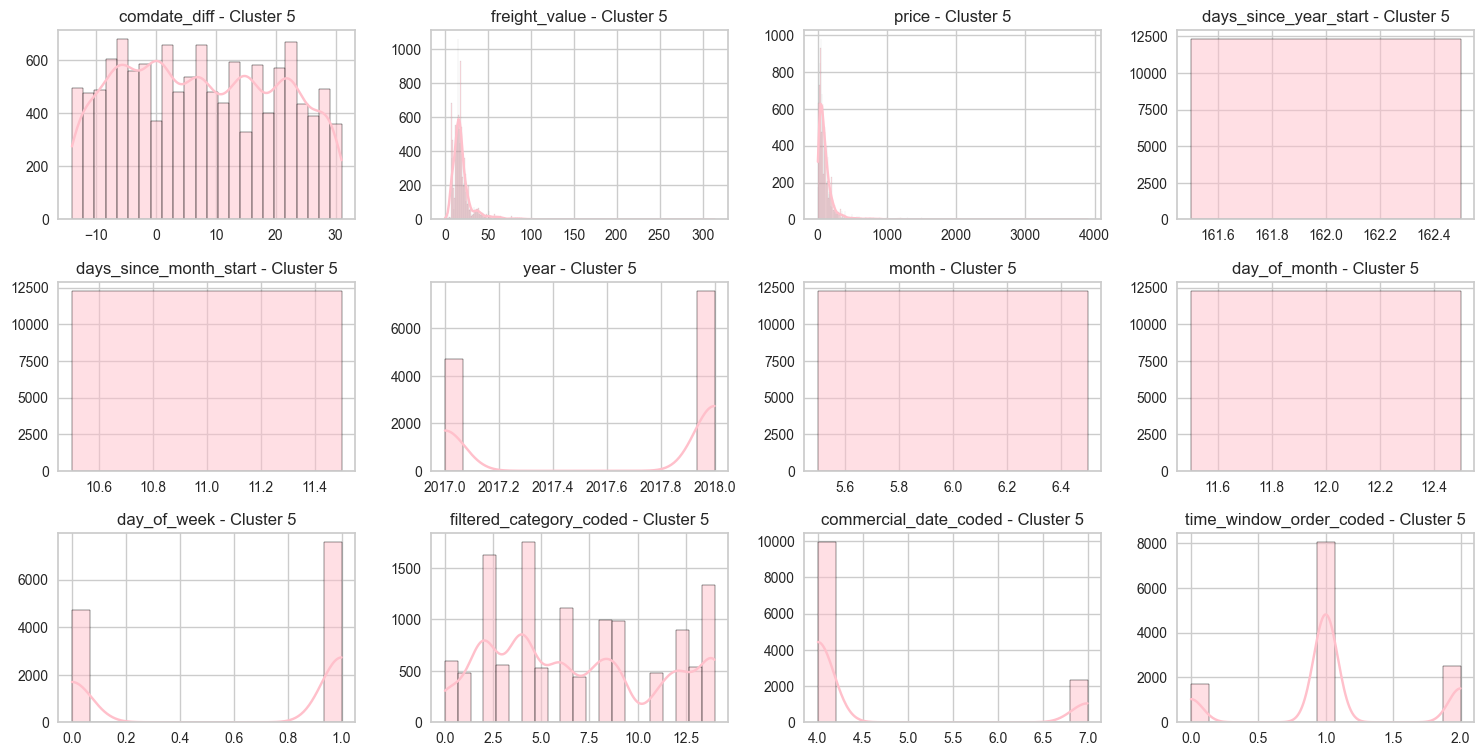

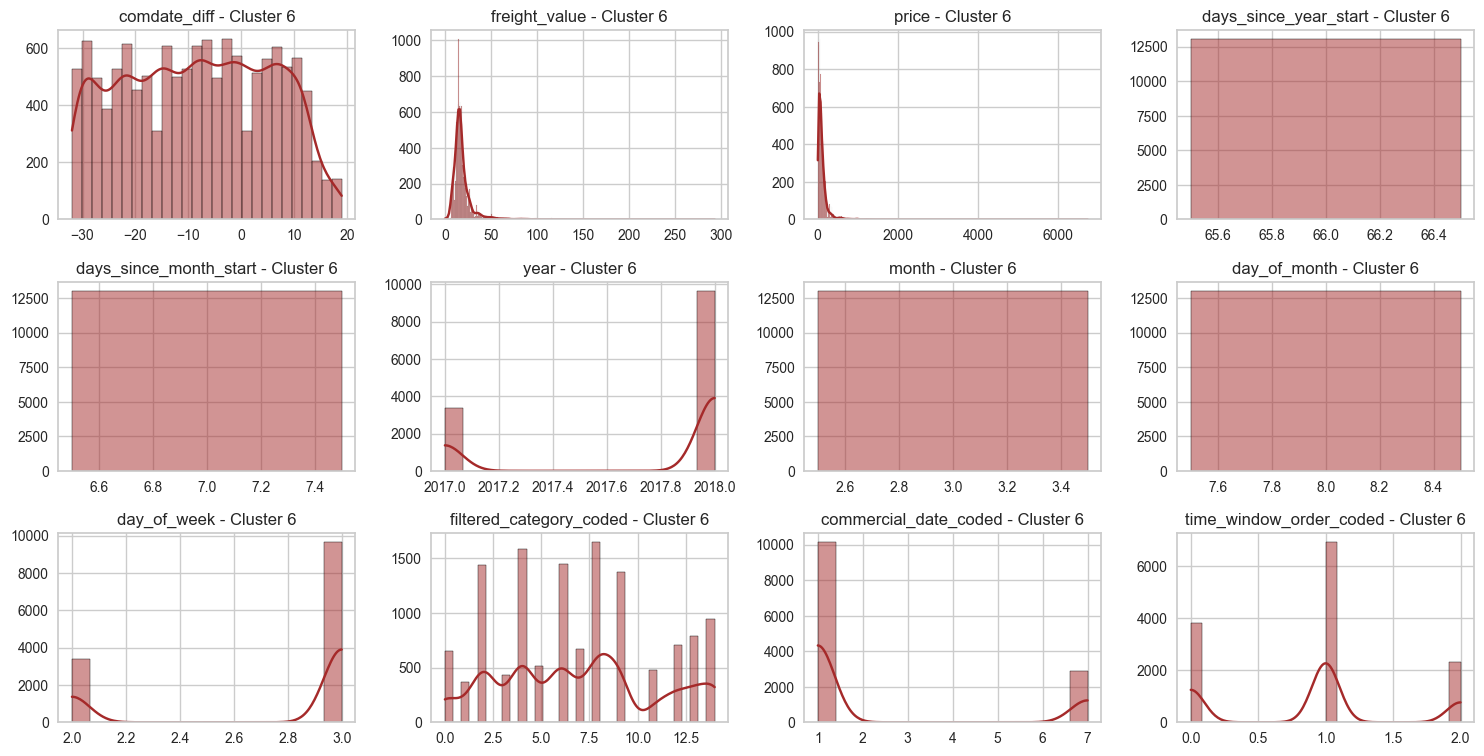

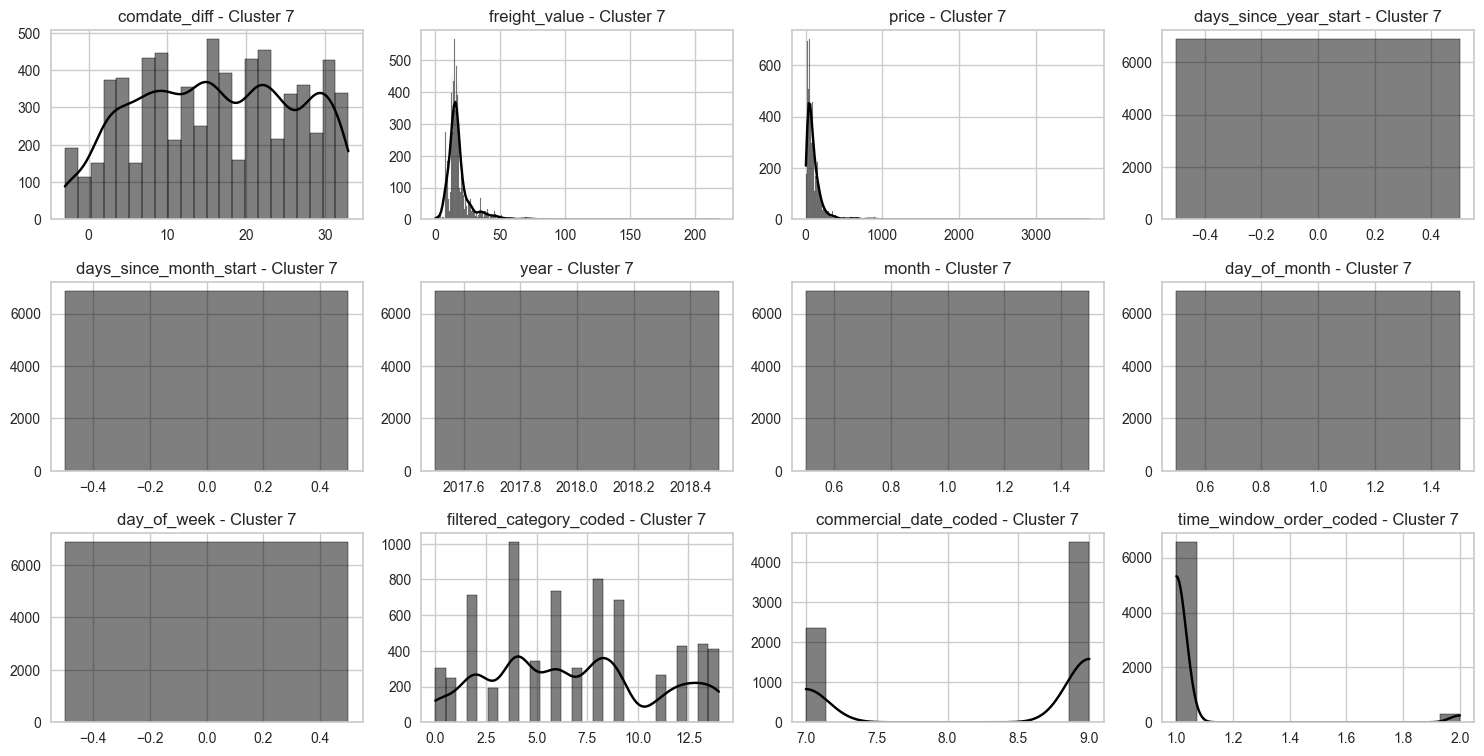

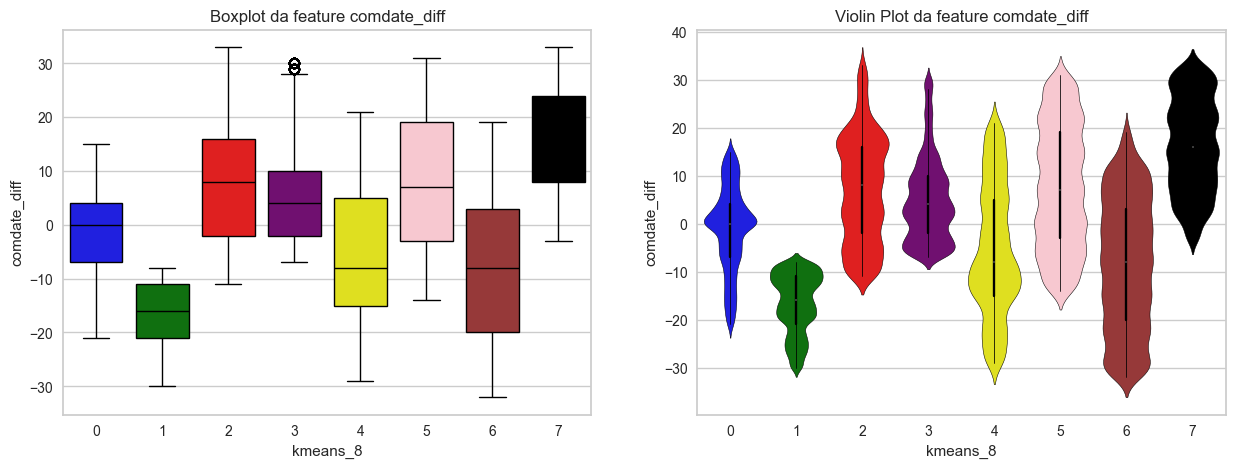

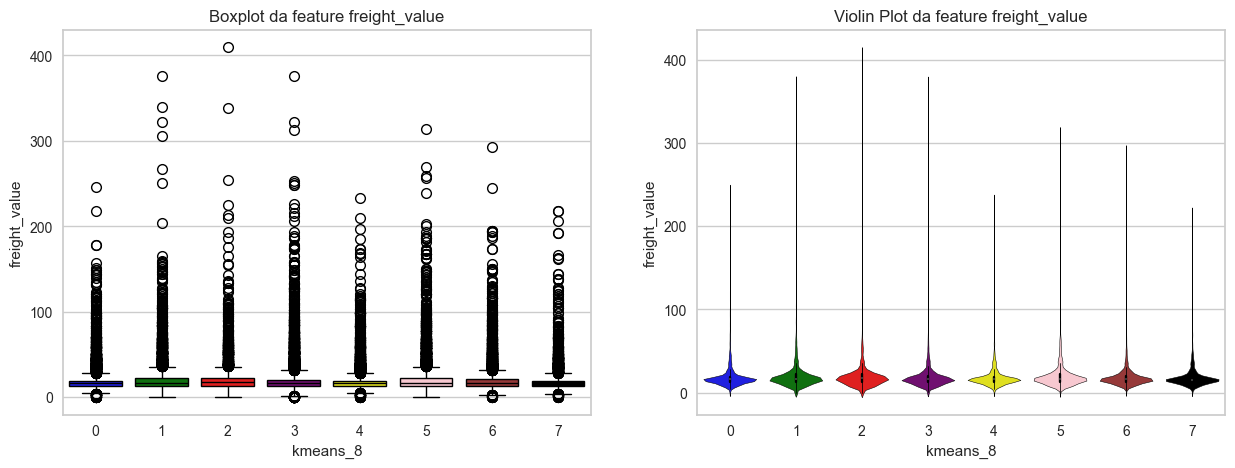

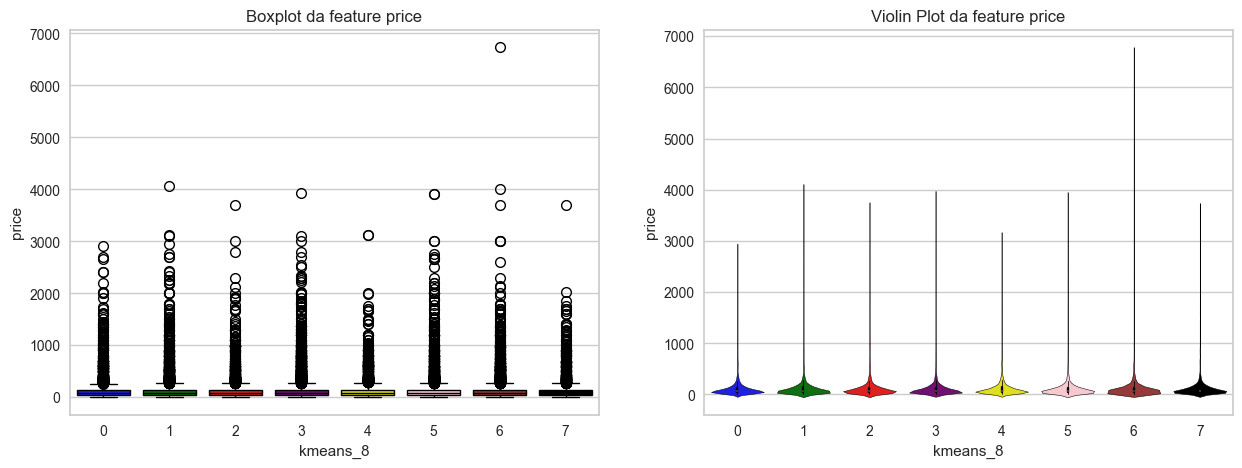

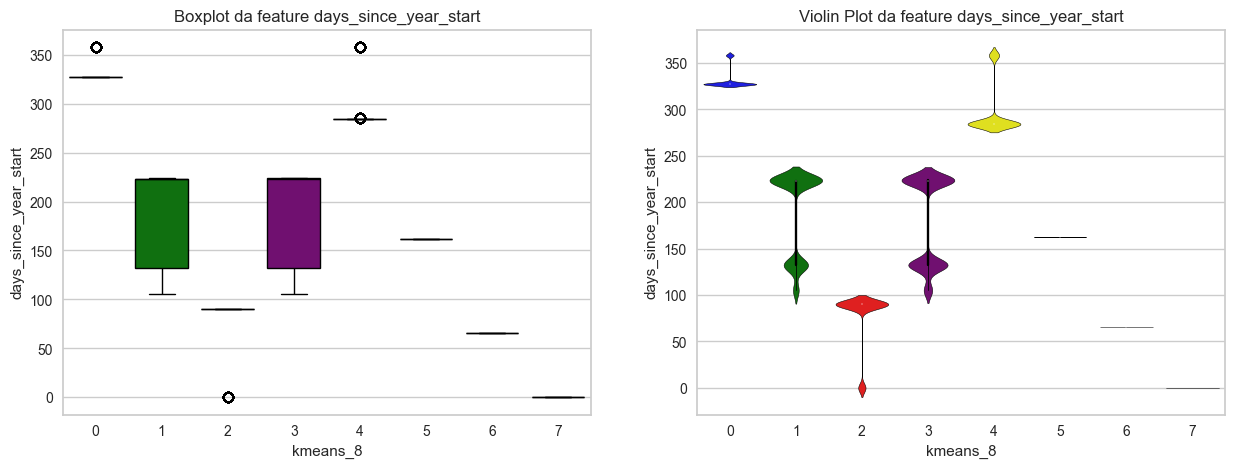

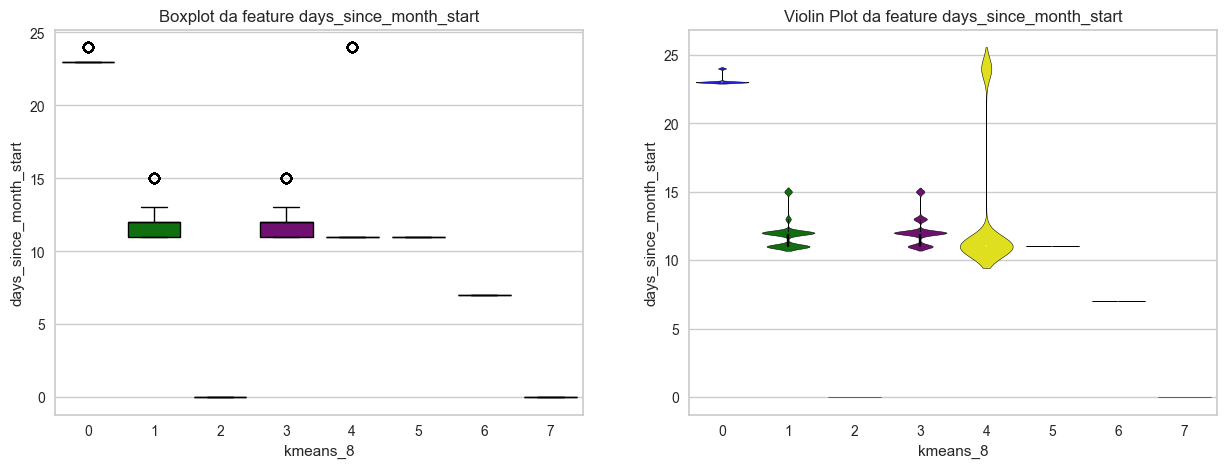

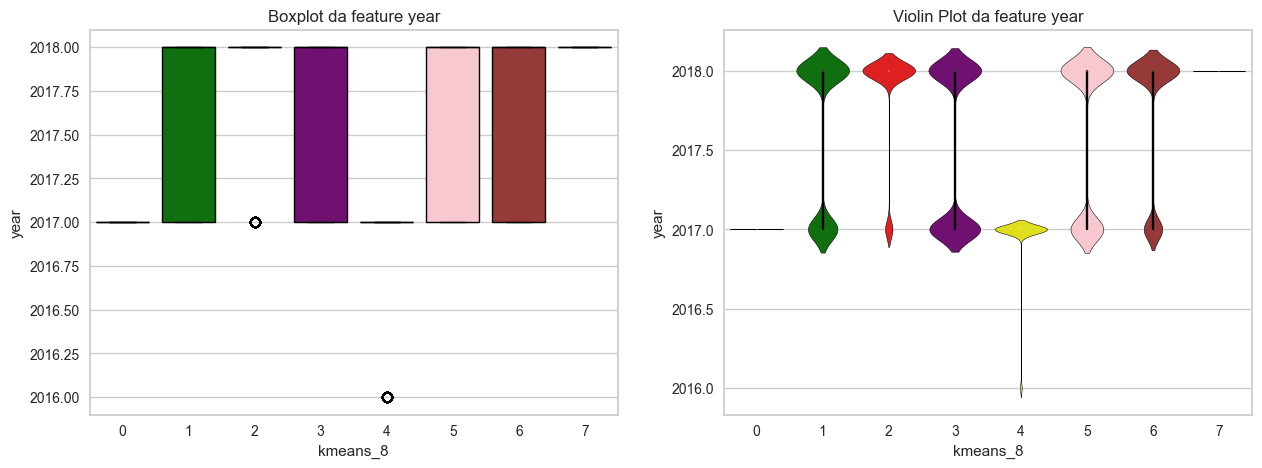

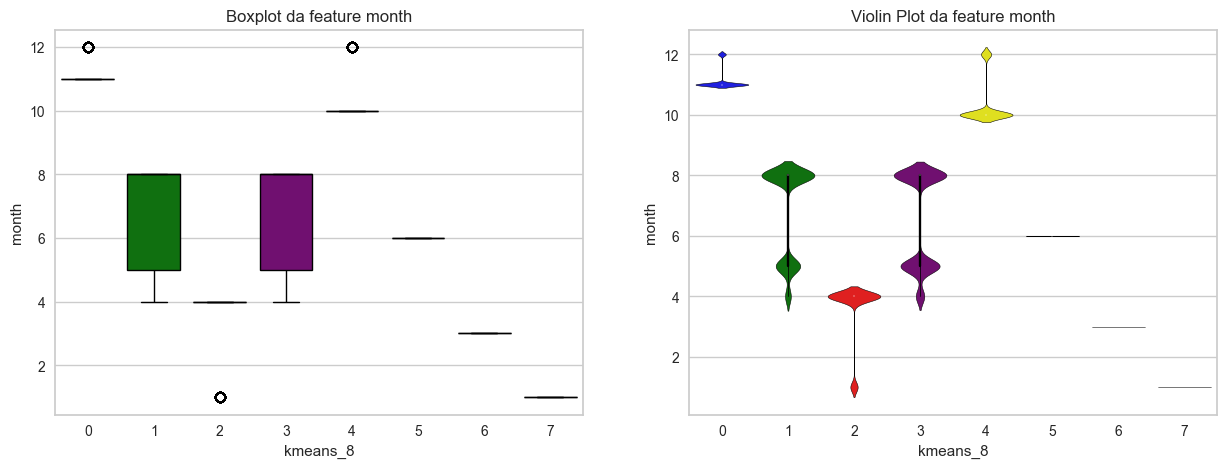

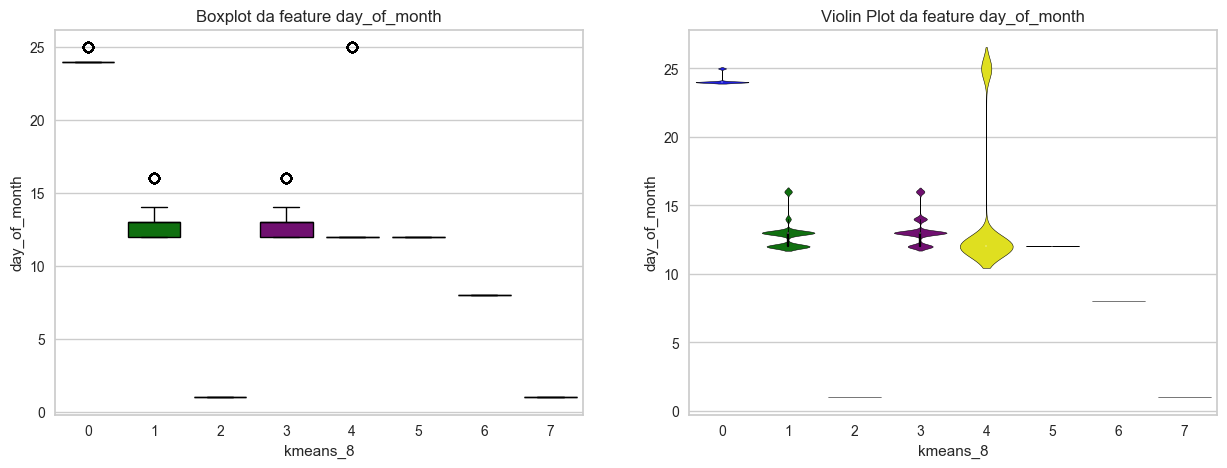

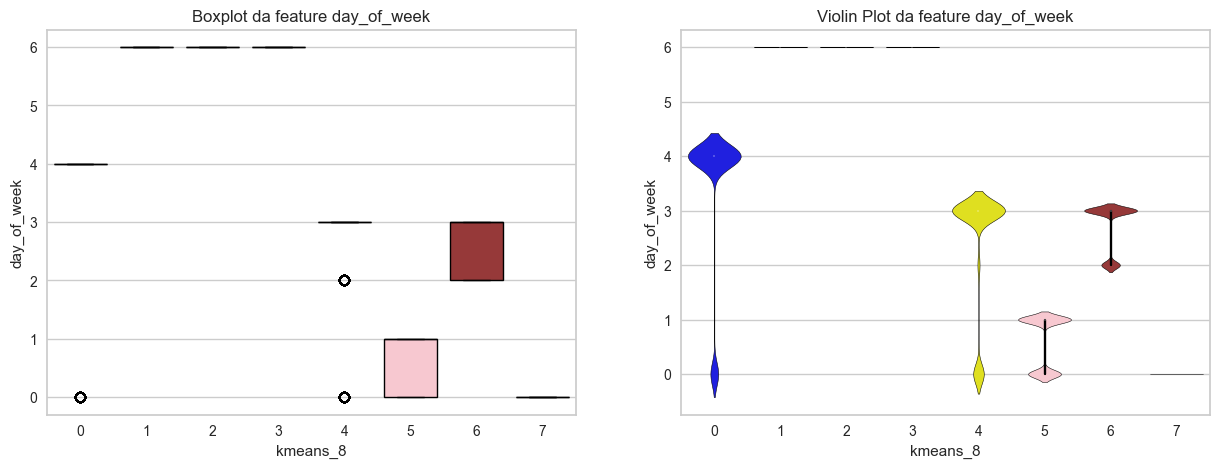

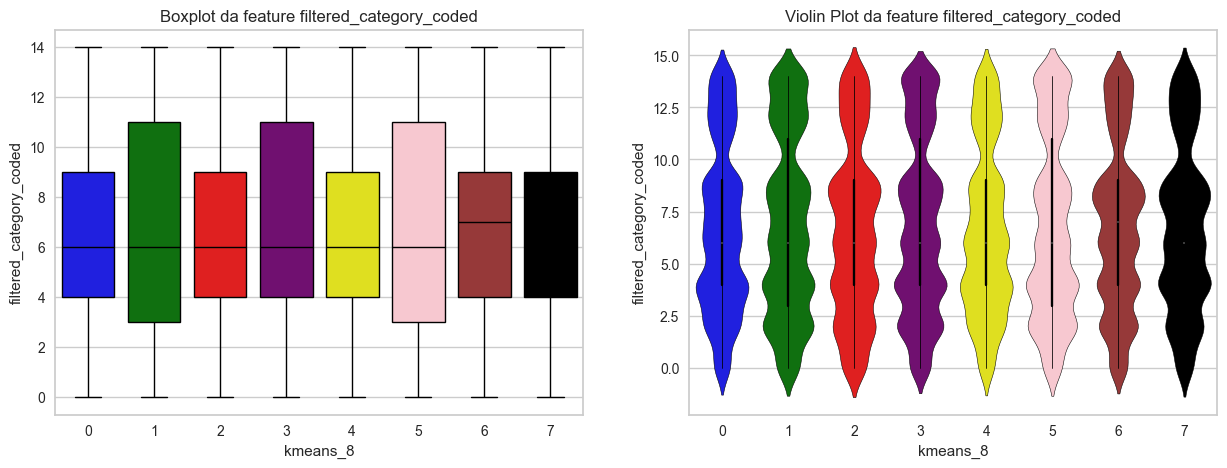

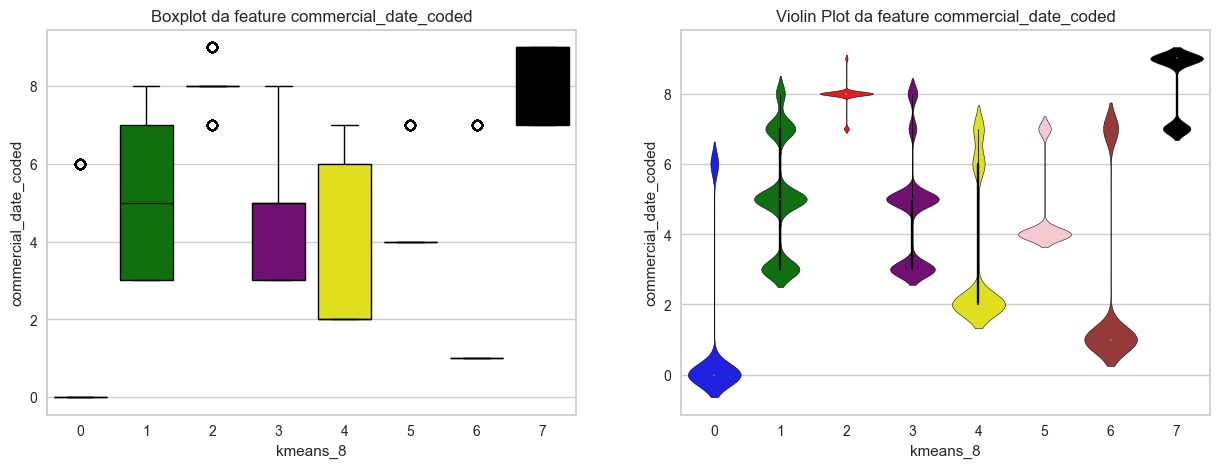

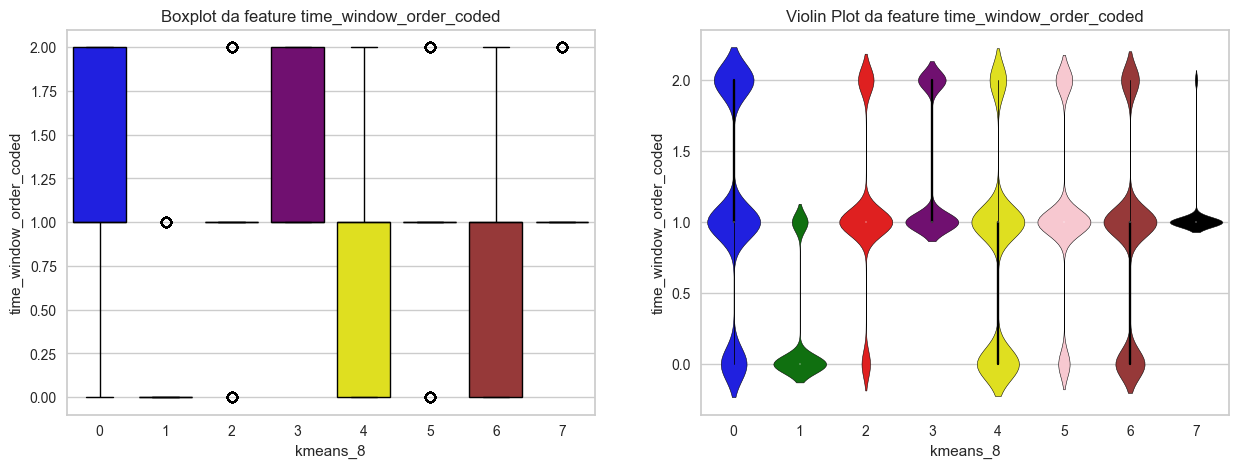

In [63]:
cluster_colors = ['blue', 'green', 'red', 'purple', 'yellow', 'pink', 'brown', 'black']
clusters_kmeans = [("kmeans_4", 4), ("kmeans_8", 8)]

for column, clusters in clusters_kmeans:
    for cluster in range(clusters):
        # Subset the DataFrame for the current cluster
        cluster_data = df_cluster[df_cluster[column] == cluster]
        df_clean = df_cluster.drop([i[0] for i in clusters_kmeans], axis=1)

        # Plot distributions for each feature
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(df_clean.columns):
            plt.subplot(4, 4, i + 1)
            sns.histplot(cluster_data[feature], kde=True, color=cluster_colors[cluster])
            plt.title(f'{feature} - Cluster {cluster}')
            plt.xlabel('')
            plt.ylabel('')

        plt.tight_layout()
        plt.show()

    for feature in df_clean.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(15, 5)

        sns.boxplot(x=column, y=feature, data=df_cluster, palette=cluster_colors[:clusters], hue=column, legend=False, ax=ax1)
        ax1.set_title(f'Boxplot da feature {feature}') 
        sns.violinplot(x=column, y=feature, data=df_cluster, palette=cluster_colors[:clusters], hue=column, legend=False, ax=ax2)
        ax2.set_title(f'Violin Plot da feature {feature}')
        
        plt.show()

## Resultado da clusterização: 4 clusters


In [75]:
df_cluster.drop("kmeans_8", axis=1).to_parquet("./../data/clean_data/clustered_kmeans_4.parquet")